# Initial

## Dataset Features

In [1]:
#channel.names                     = Combination of TMT Set and Pos.
#Sample_Run_ID                     = Arbitrary ID (remapped to 1-106).
#TMT Set                           = The set of up to 18 samples that was tested simultaneously.
#TMT Pos                           = The position in the set a sample had.
#CSF_type                          = L (lumbar) or V (ventricular) CSF sample.
#Diagnostic_classification_string3 = iNPH + comorbid condition (AD or VCI(Vascular Cognitive Impairment)).
#Cortical_biopsy_grouping          = 0 (no AD), 1 (early stage), 2 (later stage).
#Abeta_score                       = 0-3 scale of amount of pathological lesions (Abeta plaques) in brain sample.
#Tau_score                         = 0-3 scale of amount of pathological lesions (tau tangles) in brain sample.
#Gender                            = Gender of sampled individual
#Age_at_biopsy                     = Age of sampled individual
#Proteins                          = Comes in the form Q14515 (Accession number).
#Peptides                          = Accession number followed by position of peptide in protein (Q14515..533.552).

## Imports and Reading

In [114]:
#General Imports.
import pandas as pd
import numpy as np
import warnings

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

#Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

#Imputation
from sklearn.impute import SimpleImputer
from combat.pycombat import pycombat

In [3]:
#Reading CSV files.
df_proteins_median_all = pd.read_csv('Data\data files\iNPH_data_protein_median.csv', index_col=0)
df_proteins_all = pd.read_csv('Data\data files\iNPH_data_protein_nonormalization.csv', index_col=0)
df_peptides_median_all = pd.read_csv('Data\data files\iNPH_data_peptide_median.csv', index_col=0)
df_peptides_all = pd.read_csv('Data\data files\iNPH_data_peptide_nonormalization.csv', index_col=0)

## Cleaning

In [4]:
def replace_inf_with_nan(df):
    """
    Replace inf, -inf and 100 with nan.

    :param df: Dataframe to clean inf, -inf and 100 from.
    :return: df without inf, -inf and 100.
    """ 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.replace(['100', '100.0', '100.00', '100.000'], np.nan, inplace=True)
    df = df.applymap(lambda x: np.nan if isinstance(x, float) and x == 100.0 else x)

    return df

In [5]:
def remapp_id(df):
    """
    Remaps the arbitrary Sample_Run_ID with ID.

    :param df: Dataframe to remap Sample_Run_ID
    :return: df with ID.
    """ 
    value_mapping = {value: i + 1 for i, value in enumerate(df['Sample_Run_ID'].unique())}
    df['Sample_Run_ID'] = df['Sample_Run_ID'].map(value_mapping)
    return df

In [6]:
def replace_nan_with_zero(df):
    """
    Replace nan with zero.

    :param df: Dataframe to clean nan from.
    :return: df without nan.
    """ 
    return df.replace([np.nan, np.NaN], 0)

In [7]:
#Remove inf and remapp id.
df_proteins_median_all = remapp_id(replace_inf_with_nan(df_proteins_median_all))
df_proteins_all = remapp_id(replace_inf_with_nan(df_proteins_all))
df_peptides_median_all = remapp_id(replace_inf_with_nan(df_peptides_median_all))
df_peptides_all = remapp_id(replace_inf_with_nan(df_peptides_all))

## Filtration

In [120]:
def set_max_missingness_per_column(df, threshold=0.5, negative=False):
    """
    Removes columns with nan values above a threshold.

    :param df: Dataframe-base to remove NaN-heavy columns from.
    :param threshold: Threshold percentage of missingness allowed per column.
    :return: New dataframe without NaN-heavy columns.
    """ 
    if not negative:
        nan_percentage = (df.isna().mean()).round(4)
        selected_columns = nan_percentage[nan_percentage <= threshold].index
        return df[selected_columns]
    
    nan_percentage = (df.isna().mean()).round(4)
    selected_columns = nan_percentage[nan_percentage >= threshold].index
    return df[selected_columns]

In [9]:
def get_missingness_based_on_column(df, col):
    """
    Gets missingness based on column groups.

    :param df: Dataframe to check columns for missingness.
    :param col: Particular column to group by.
    :return: Dictionary with groups and missingness.
    """ 
    return df.groupby(col).apply(lambda group: group.isna().mean().mean()).round(4).to_dict()

# Exploration

## Distribution

### CSF Type Samples

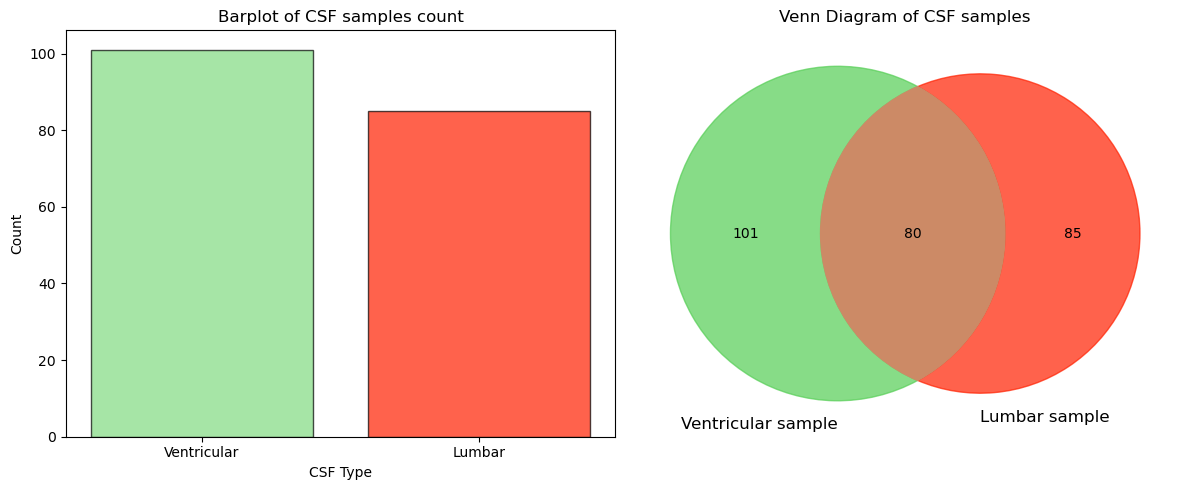

In [10]:
#--- TYPES OF SAMPLES BARPLOT AND VENN DIAGRAM ---#
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#Barplot
value_counts = df_proteins_median_all['CSF_type'].value_counts()

axs[0].bar(value_counts.index, value_counts, color=['#80DA80', '#FF2000'], edgecolor='black', alpha=0.7)
axs[0].set_xlabel('CSF Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Barplot of CSF samples count')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Ventricular', 'Lumbar'], rotation='horizontal')

#Venn Diagram
pers_id_with_V = set(df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V']['Sample_Run_ID'])
pers_id_with_L = set(df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'L']['Sample_Run_ID'])

v = venn2(subsets=(len(pers_id_with_V), len(pers_id_with_L), len(pers_id_with_V & pers_id_with_L)),
      set_labels=('Ventricular sample', 'Lumbar sample'), ax=axs[1])
v.get_patch_by_id('10').set_color('#55CE55')
v.get_patch_by_id('10').set_alpha(0.7)
v.get_patch_by_id('01').set_color('#FF2000')
v.get_patch_by_id('01').set_alpha(0.7)
v.get_patch_by_id('11').set_color('#CC8A66')
v.get_patch_by_id('11').set_alpha(1)

axs[1].set_title('Venn Diagram of CSF samples')

plt.tight_layout()
plt.show()

This shows that we have slightly more ventricular samples compared to lumbar samples. The Venn diagram further tells us that we have both samples from 80 individuals, 21 ventricular-only samples and 5 lumbar-only samples. This totals to 186 samples. Considering the low amount of samples, splitting the dataset into ventricular and lumbar samples may be hard, but may give some information during the exploration phase.

## Missingness

### Proteins & Peptides

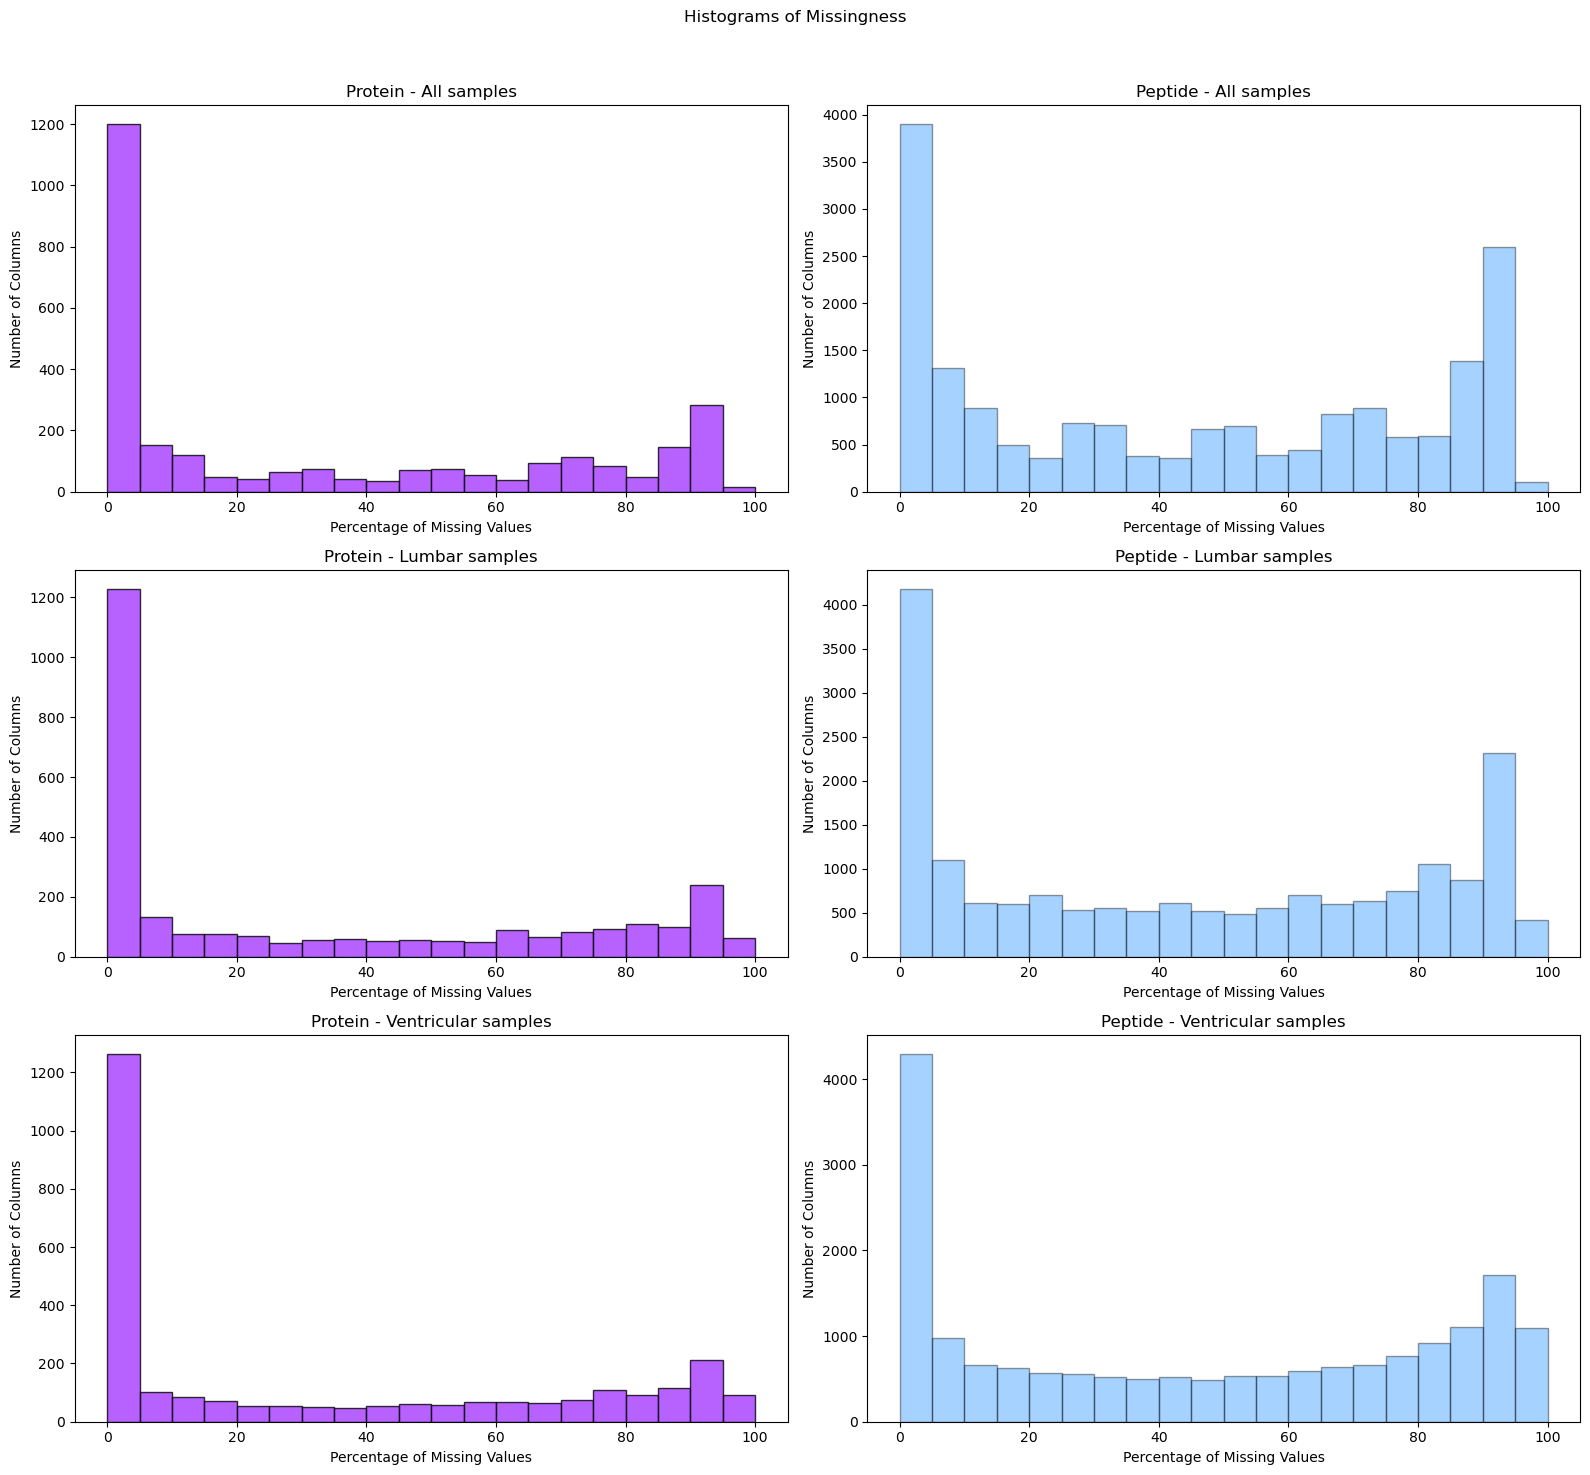

In [11]:
#Missingness histograms of all samples, lumbar and ventricular.
sample_types = [('All samples', df_proteins_median_all.iloc[:,11:], df_peptides_median_all.iloc[:,11:]),
                ('Lumbar samples', df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'L'].iloc[:, 11:],
                 df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'L'].iloc[:, 11:]),
                ('Ventricular samples', df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V'].iloc[:, 11:],
                 df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'V'].iloc[:, 11:])]

fig, axes = plt.subplots(len(sample_types), 2, figsize=(16, 5 * len(sample_types)))
fig.suptitle('Histograms of Missingness')

for i, (sample_type, protein_data, peptide_data) in enumerate(sample_types):
    missingness_protein = (protein_data.isna().mean() * 100).round(2)
    missingness_peptide = (peptide_data.isna().mean() * 100).round(2)

    axes[i, 0].hist(missingness_protein, bins=np.arange(0, 101, 5), color='#a539ff', edgecolor='black', alpha=0.8)
    axes[i, 0].set_title(f'Protein - {sample_type}')
    axes[i, 0].set(xlabel='Percentage of Missing Values', ylabel='Number of Columns')

    axes[i, 1].hist(missingness_peptide, bins=np.arange(0, 101, 5), color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[i, 1].set_title(f'Peptide - {sample_type}')
    axes[i, 1].set(xlabel='Percentage of Missing Values', ylabel='Number of Columns')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Overall, the peptide missingness is higher compared to the protein missingness. This is most likely due to each protein consisting of multiple peptides, so not only is the peptide dataset larger, the qualifications for finding a protein is easier than finding five peptides. This missingness seems to be consistent in both lumbar and ventricular samples. There are 2795 proteins and 18305 peptides, meaning there are roughly 6.5 peptides per protein in the datasets.

### Feature Missingness

In [12]:
#Getting missingness based on columns into dictionary.
cols = ["Sample_Run_ID", "TMT Set", "TMT Pos", "CSF_type", "Cortical_biopsy_grouping", "Gender", "Age_at_biopsy"]
sample = ["All samples", "Lumbar", "Ventricular"]

dict_missingness = {}
for col in cols:
    dict_missingness[f'{col}_Protein'] = get_missingness_based_on_column(df_proteins_median_all, col)
    dict_missingness[f'{col}_Peptide'] = get_missingness_based_on_column(df_peptides_median_all, col)
    dict_missingness[f'{col}_Protein_Lumbar'] = get_missingness_based_on_column(df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'L'], col)
    dict_missingness[f'{col}_Peptide_Lumbar'] = get_missingness_based_on_column(df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'L'], col)
    dict_missingness[f'{col}_Protein_Ventricular'] = get_missingness_based_on_column(df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V'], col)
    dict_missingness[f'{col}_Peptide_Ventricular'] = get_missingness_based_on_column(df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'V'], col)

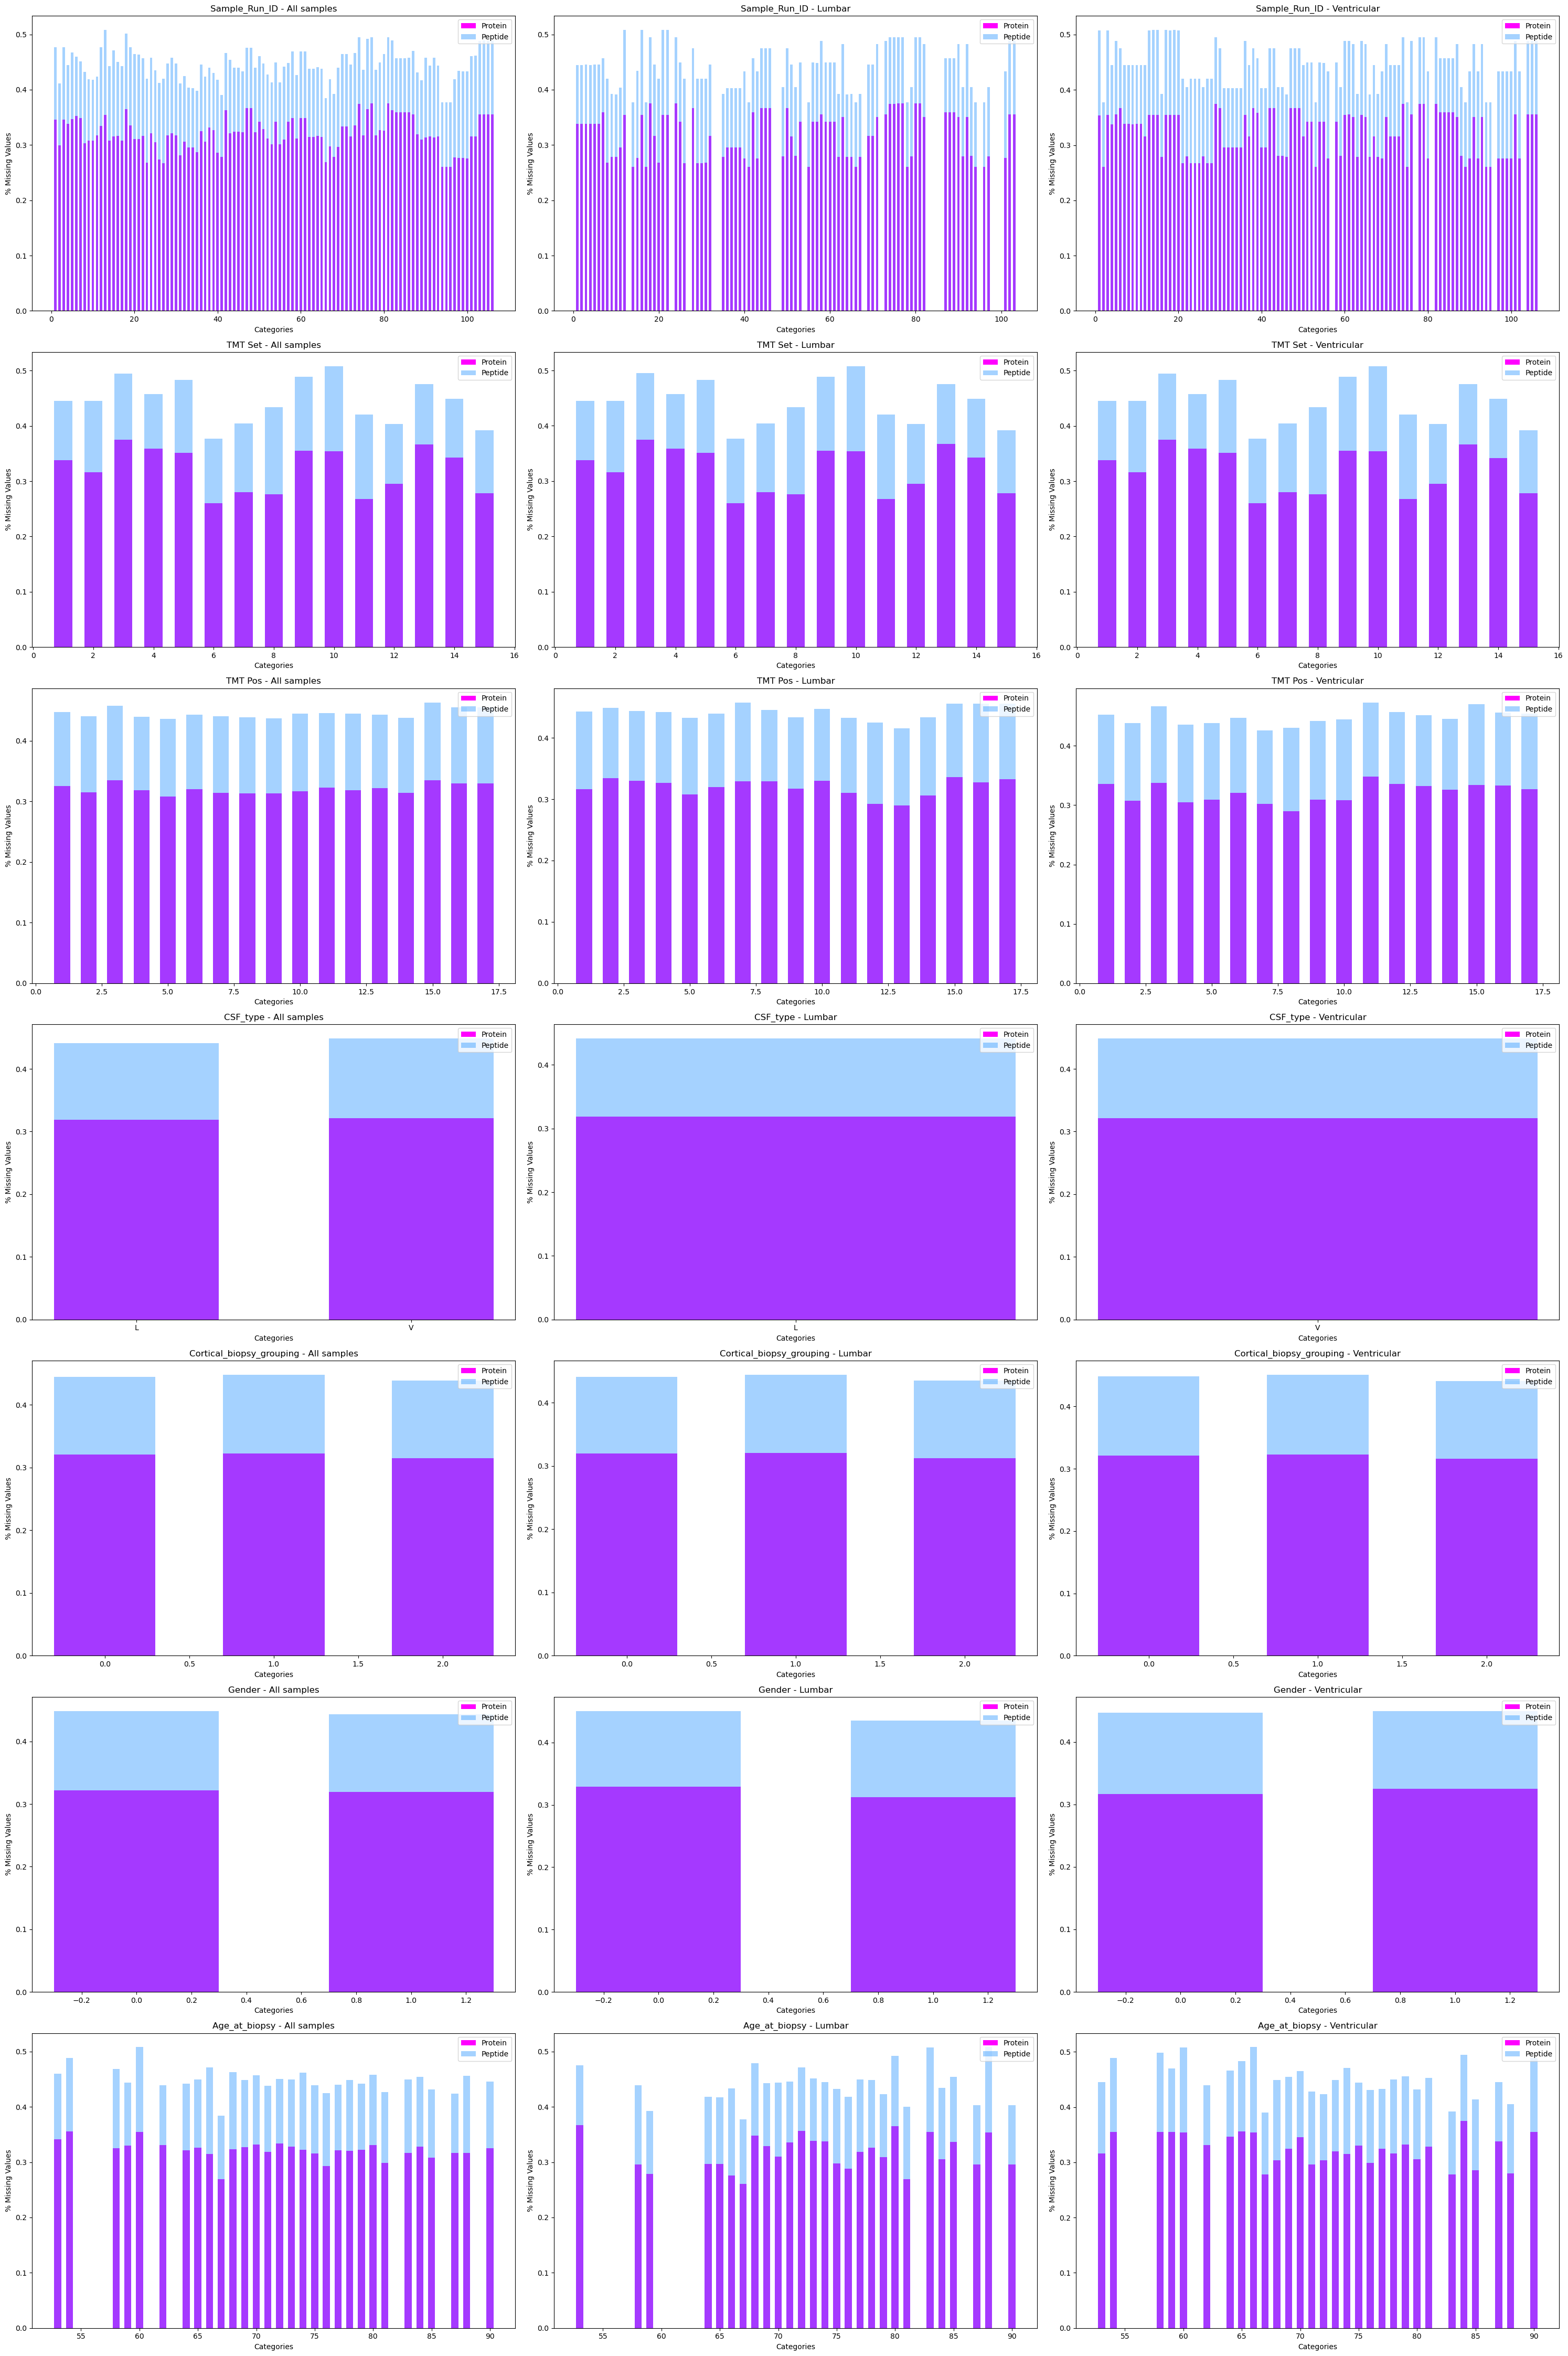

In [13]:
#--- PLOTTING BARCHARTS BASED OIN MISSINGNESS ---#
fig, axes = plt.subplots(7, 3, figsize=(30, 45))

for i in range(7):
    for j in range(3):
        dataset_name1, data1 = list(dict_missingness.items())[((i * 6) + (j * 2))]
        dataset_name2, data2 = list(dict_missingness.items())[((i * 6) + (j * 2) + 1)]
        values1 = list(data1.values())
        values2 = list(data2.values())

        categories = list(data1.keys())
        width = 0.6 

        axes[i, j].bar(categories, values1, width, color='magenta', label='Protein')
        axes[i, j].bar(categories, values2, width, color='dodgerblue', label='Peptide', alpha=0.4)

        axes[i, j].set_title(cols[i] + " - " + sample[j])
        axes[i, j].set_xlabel('Categories')
        axes[i, j].set_ylabel('% Missing Values')
        axes[i, j].legend(loc='upper right')

plt.tight_layout()
plt.show()

Overall, the missingness based on sample type (lumbar or ventricular) or structure type (protein or peptide) does not seem to have any particular correlation. Most of this missingness seems to be similar the groups, with peptide continuously having more missingness than proteins.  TMT Set seems to be the category that influenced the missingness the most.

### Individual Proteins and Peptides Missingness

In [14]:
def plot_columns_with_highest_missing_ratio(dataframe, title_desc, n=5, plot_y_ticks = False):
    """
    Plot n columns with the highest ratio of missing values in the given DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.
    - n (int): Number of columns to plot. Default is 5.
    """
    missing_ratios = dataframe.isnull().mean()
    sorted_columns = missing_ratios.sort_values(ascending=False).index[:n]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_ratios[sorted_columns], y=sorted_columns, color='skyblue')
    if not plot_y_ticks:
        plt.yticks([])
    plt.title(f'Top {n} {title_desc} columns with highest missing value ratios')
    plt.xlabel('Missing Value Ratio')
    plt.ylabel('Columns')
    plt.show()

#### Individual Proteins Missingness

##### Protein Lumbar Samples

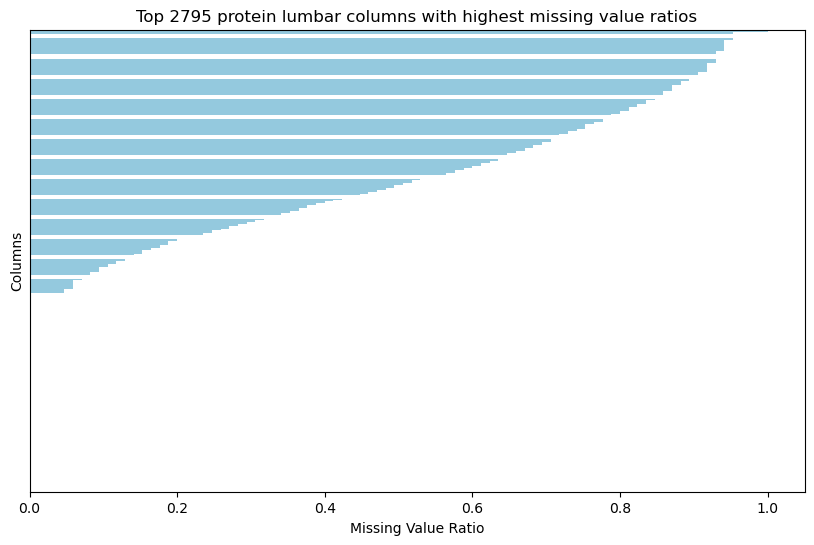

In [15]:
#Missingness of individual proteins in the dataset from lumbar samples. Proteins higher up have more missingness.
plot_columns_with_highest_missing_ratio(df_proteins_all[df_proteins_all['CSF_type'] == 'L'].iloc[:,11:], n=df_proteins_all[df_proteins_all['CSF_type'] == 'L'].iloc[:,11:].shape[1], title_desc="protein lumbar")

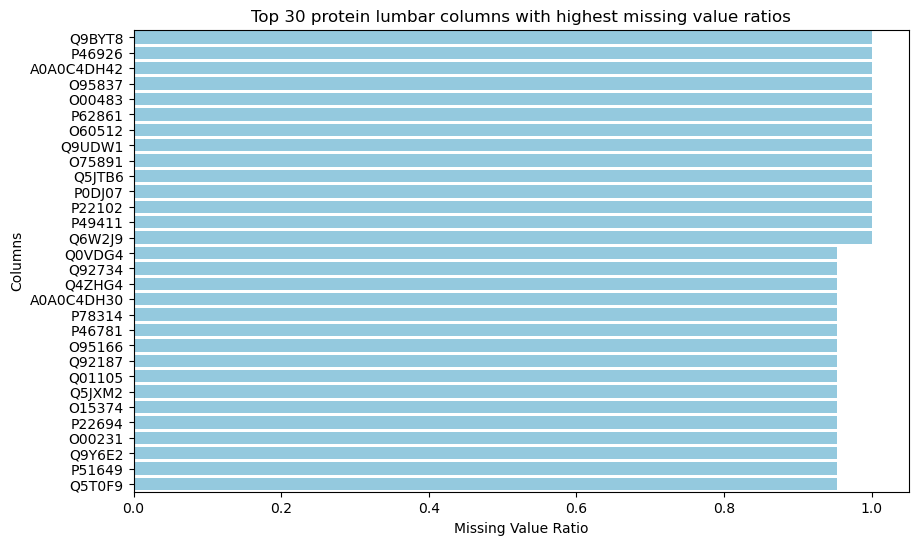

In [16]:
#Missingness of individual proteins in the dataset from lumbar samples. Top 30 samples with protein names.
plot_columns_with_highest_missing_ratio(df_proteins_all[df_proteins_all['CSF_type'] == 'L'].iloc[:,11:], n=30, plot_y_ticks=True, title_desc="protein lumbar")

##### Protein Ventricular Samples

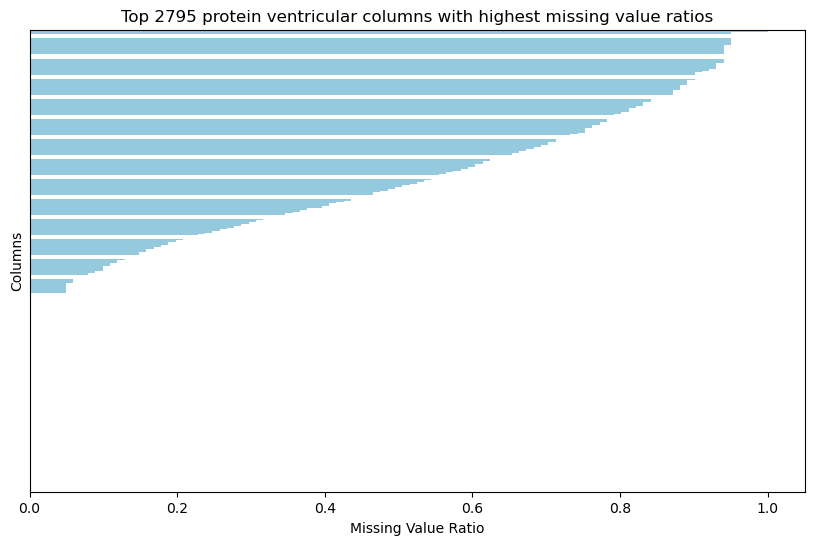

In [17]:
#Missingness of individual proteins in the dataset from ventricular samples. Proteins higher up have more missingness.
plot_columns_with_highest_missing_ratio(df_proteins_all[df_proteins_all['CSF_type'] == 'V'].iloc[:,11:], n=df_proteins_all[df_proteins_all['CSF_type'] == 'V'].iloc[:,11:].shape[1], title_desc="protein ventricular")

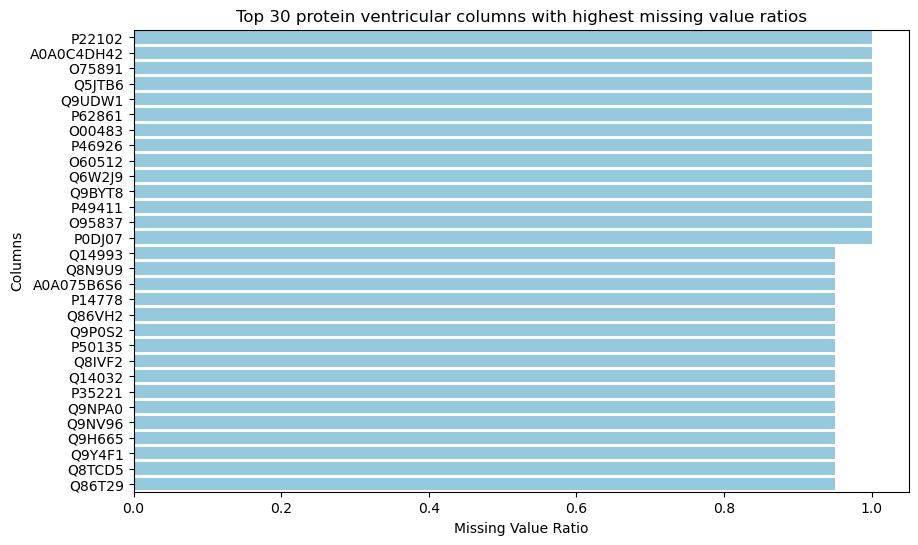

In [18]:
#Missingness of individual proteins in the dataset from ventricular samples. Top 30 samples with protein names.
plot_columns_with_highest_missing_ratio(df_proteins_all[df_proteins_all['CSF_type'] == 'V'].iloc[:,11:], n=30, plot_y_ticks=True, title_desc="protein ventricular")

#### Individual Peptides Missingness

##### Peptide Lumbar Samples

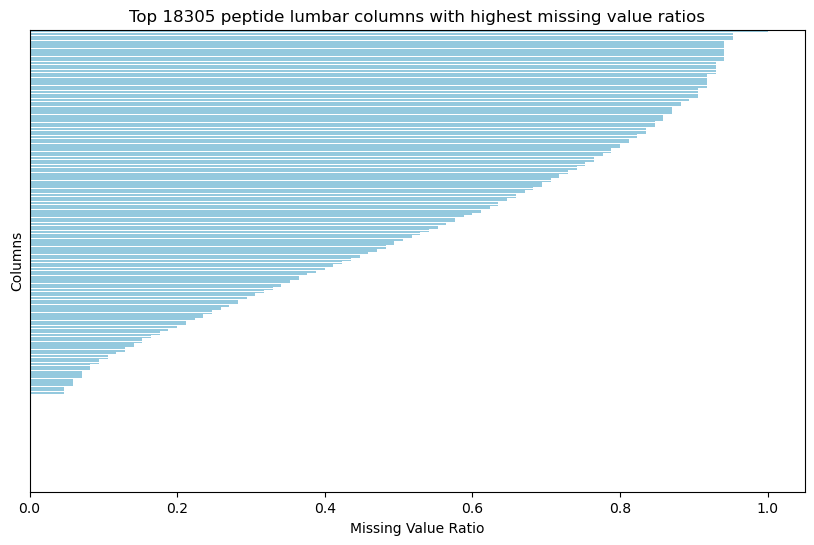

In [19]:
#Missingness of individual peptides in the dataset from lumbar samples. Peptides higher up have more missingness.
plot_columns_with_highest_missing_ratio(df_peptides_all[df_peptides_all['CSF_type'] == 'L'].iloc[:,11:], n=df_peptides_all[df_peptides_all['CSF_type'] == 'L'].iloc[:,11:].shape[1], title_desc="peptide lumbar")

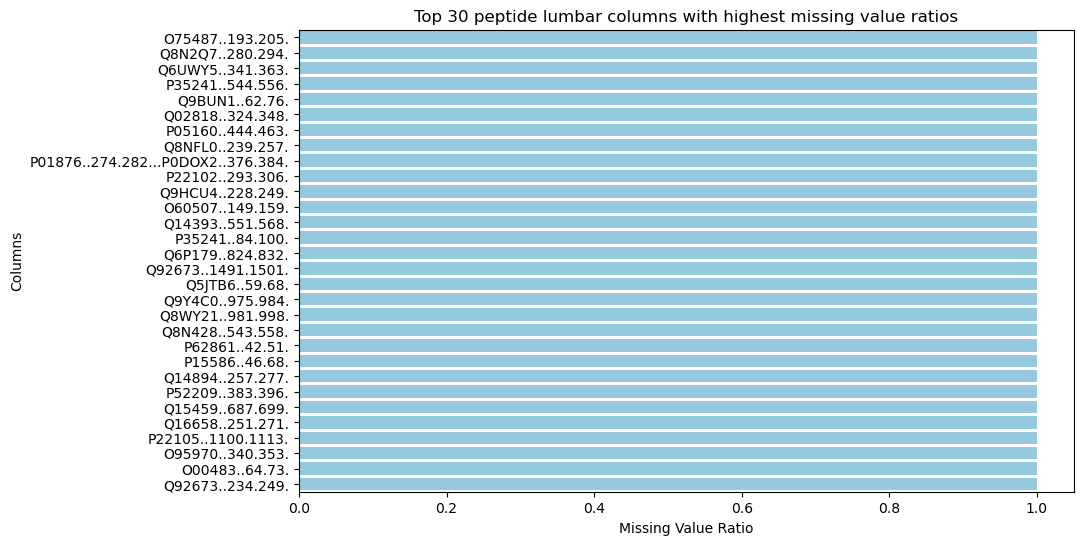

In [20]:
#Missingness of individual peptides in the dataset from ventricular samples. Top 30 samples with peptides names.
plot_columns_with_highest_missing_ratio(df_peptides_all[df_peptides_all['CSF_type'] == 'L'].iloc[:,11:], n=30, plot_y_ticks=True, title_desc="peptide lumbar")

##### Peptide Ventricular Samples

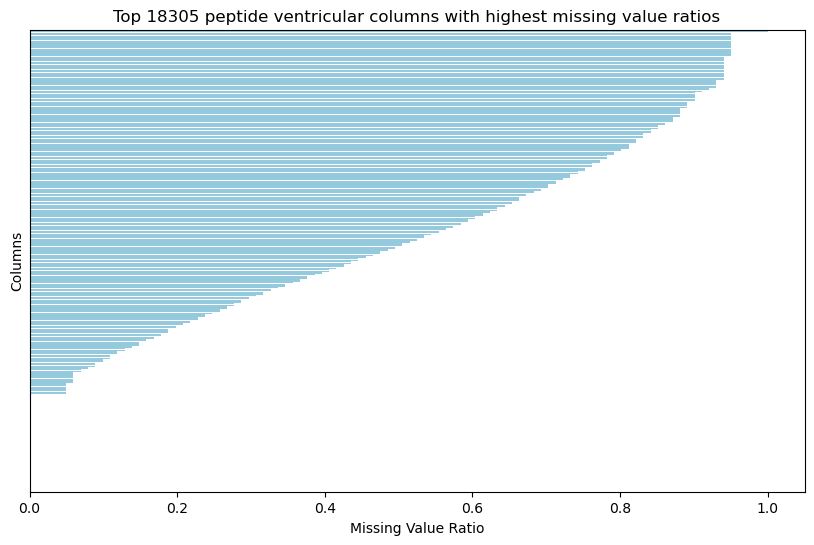

In [21]:
#Missingness of individual peptides in the dataset from ventricular samples. Peptides higher up have more missingness.
plot_columns_with_highest_missing_ratio(df_peptides_all[df_peptides_all['CSF_type'] == 'V'].iloc[:,11:], n=df_peptides_all[df_peptides_all['CSF_type'] == 'V'].iloc[:,11:].shape[1], title_desc="peptide ventricular")

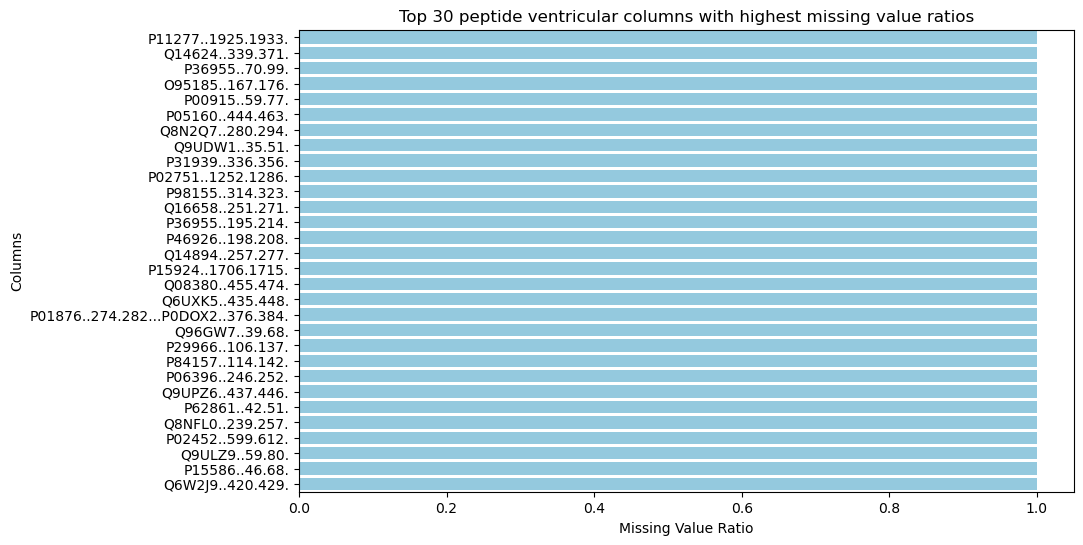

In [22]:
#Missingness of individual peptides in the dataset from ventricular samples. Top 30 samples with peptides names.
plot_columns_with_highest_missing_ratio(df_peptides_all[df_peptides_all['CSF_type'] == 'V'].iloc[:,11:], n=30, plot_y_ticks=True, title_desc="peptide ventricular")

## Dimensionality Reduction

In [23]:
def do_scree_plot_data(pca):
    """
    Gets Scree Plot Data from a PCA.

    :param pca: PCA already fit and processed.
    :return: PCA Scree Plot Data.
    """ 
    pca_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
    pca_labels = ['PC' + str(x) for x in range(1, len(pca_var)+1)]
    return (pca_var, pca_labels)

In [24]:
def do_PCA_on_DF(df, n_components=10):
    """
    Does PCA on a DF.

    :param df: Dataframe-base to perform PCA on.
    :param n_components: Number of PCA components to find.
    :return: PCA Scree Plot Data.
    """ 
    df_clean = set_max_missingness_per_column(df, 0)
    pca = PCA(n_components=n_components)
    pca.fit(df_clean)
    
    return pca

### PCA - (No Missingness)

#### Median

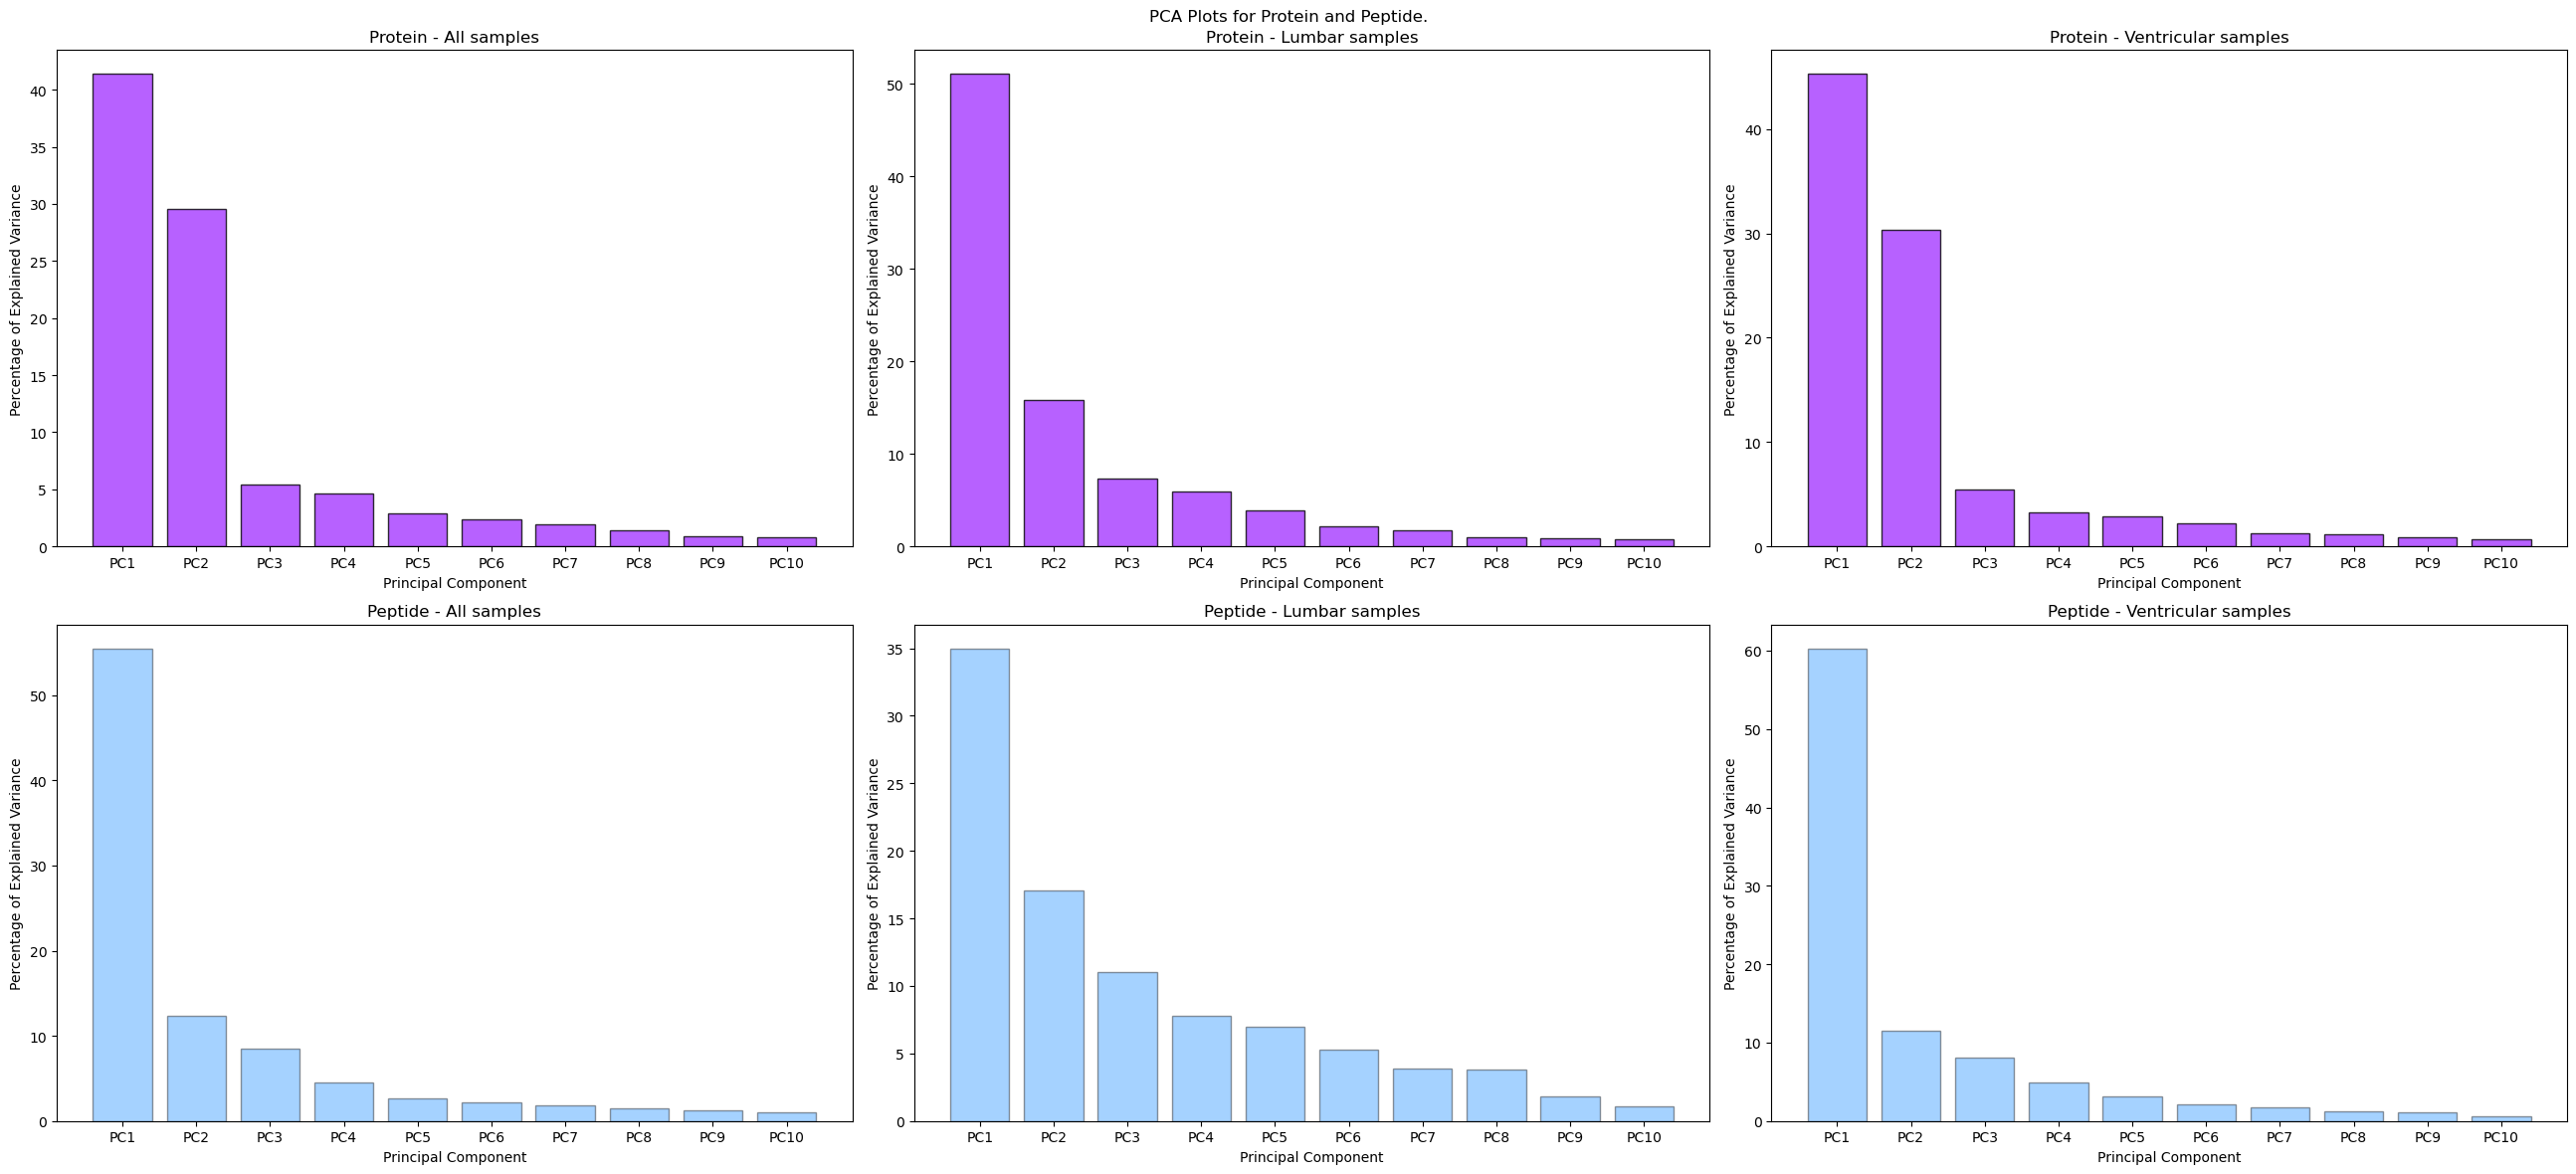

In [25]:
#--- RUNNING PCA CALCULATION AND PLOTTING - MEDIAN NORMALIZED---#
datasets_protein = [df_proteins_median_all.iloc[:,11:], df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'L'].iloc[:, 11:],
                    df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V'].iloc[:, 11:]]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [df_peptides_median_all.iloc[:,11:], df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'L'].iloc[:, 11:],
                     df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'V'].iloc[:, 11:]]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_scree_plot_data(do_PCA_on_DF(dataset_protein))
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_scree_plot_data(do_PCA_on_DF(dataset_peptide))
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

The PCA graphs show that all samples and variations of some form of higher importance in PC1 (and in some cases PC2), which is expected.

#### Non Normalized

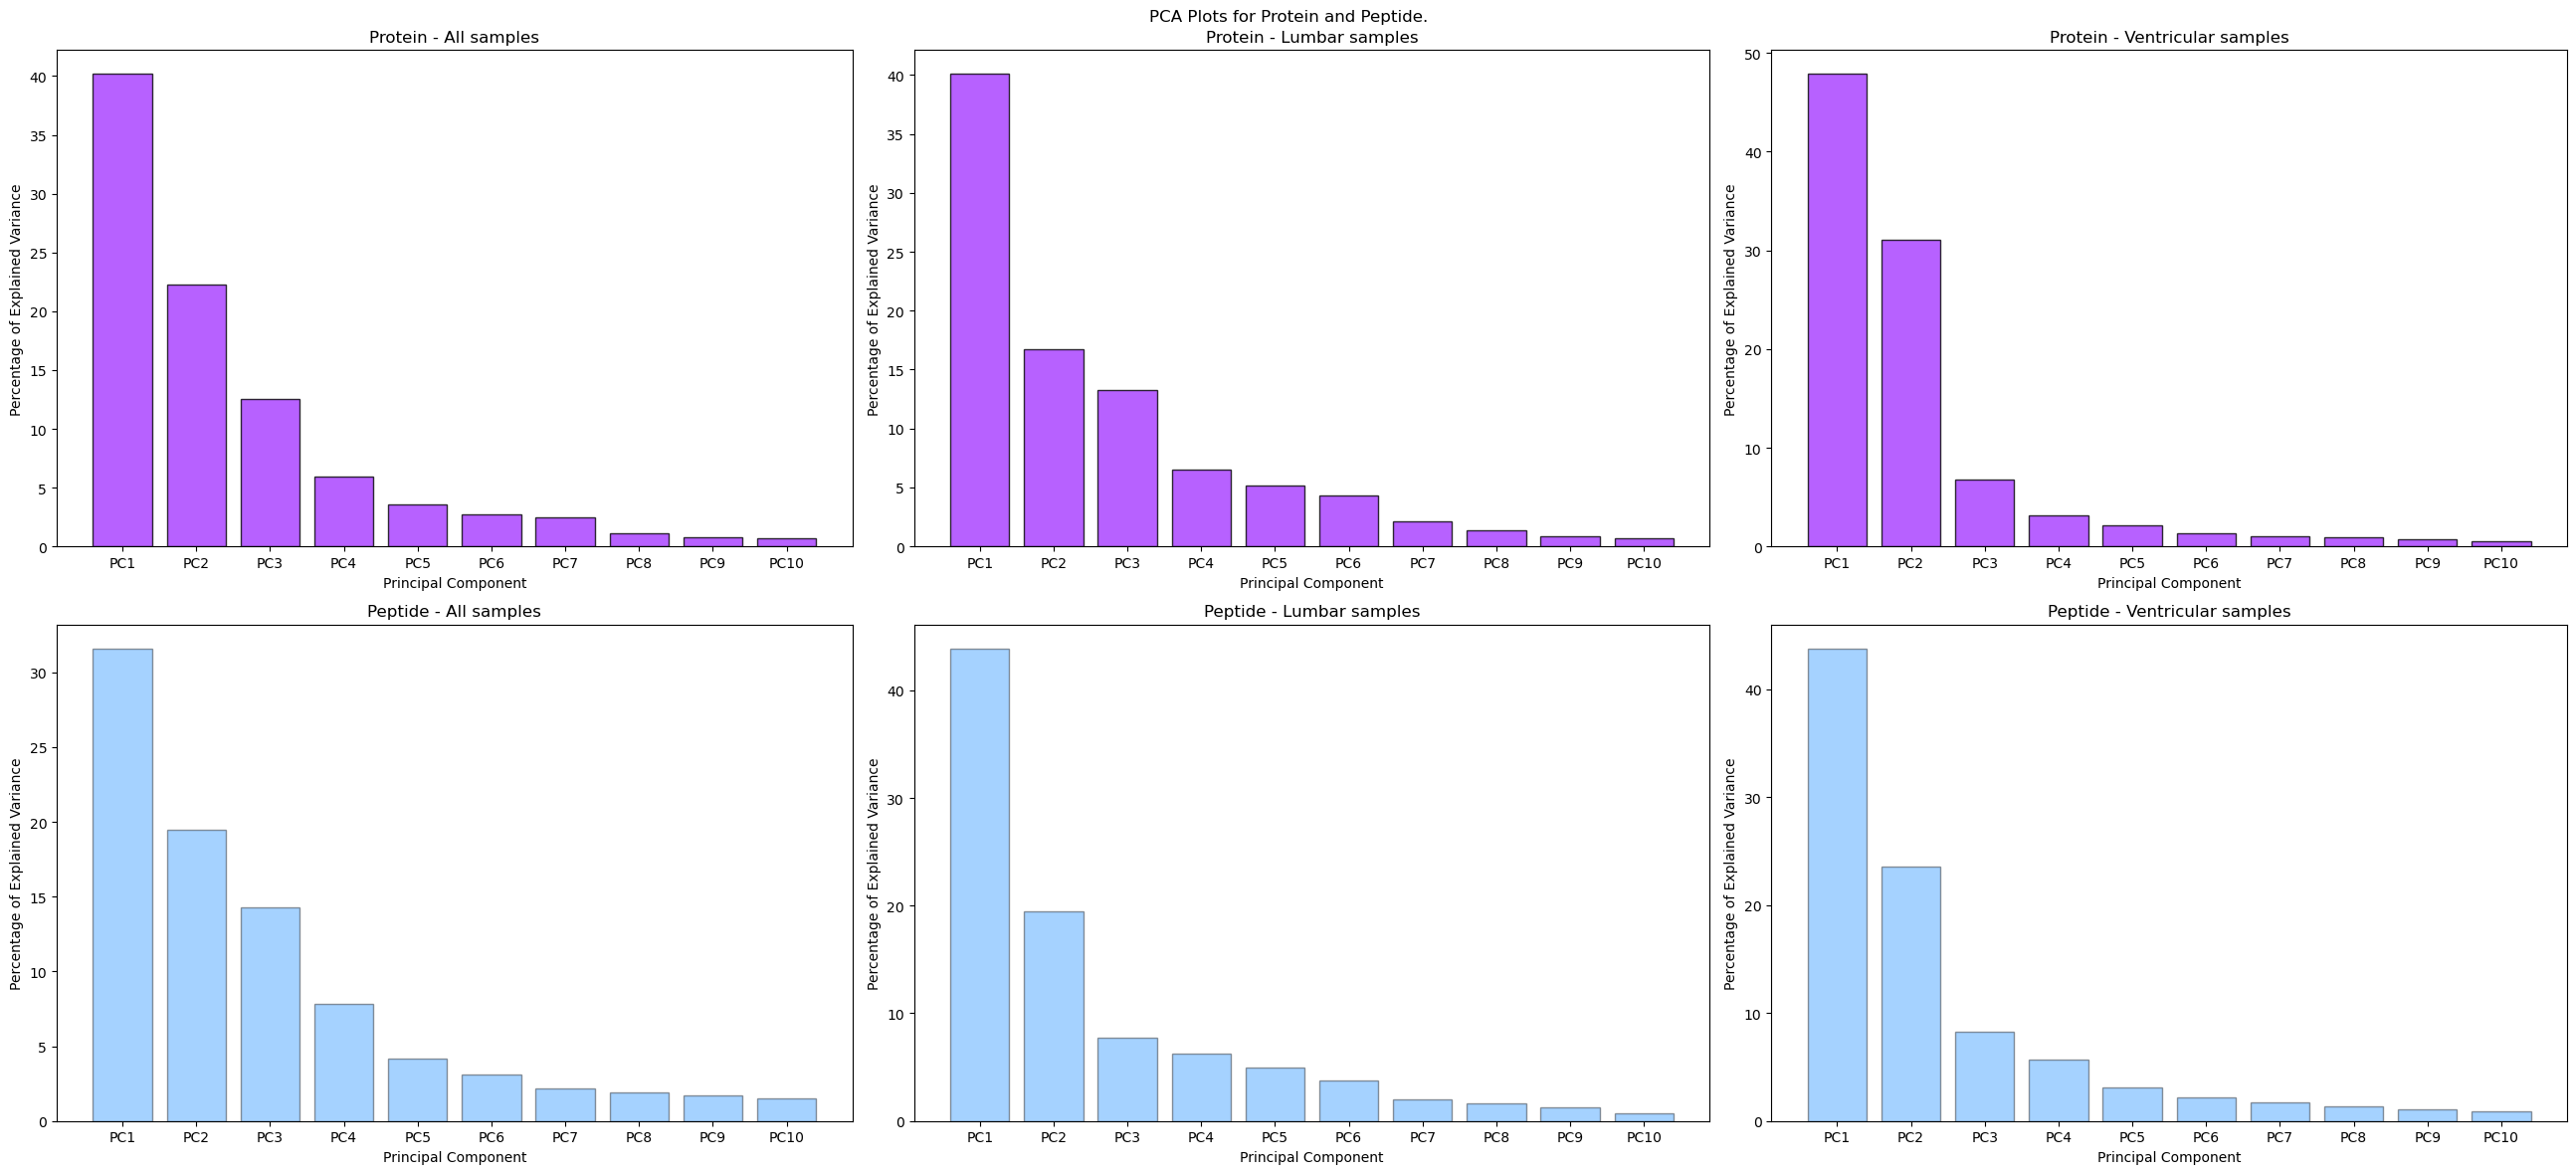

In [26]:
#--- RUNNING PCA CALCULATION AND PLOTTING - NON NORMALIZED---#
datasets_protein = [df_proteins_all.iloc[:,11:], df_proteins_all[df_proteins_all['CSF_type'] == 'L'].iloc[:, 11:],
                    df_proteins_all[df_proteins_all['CSF_type'] == 'V'].iloc[:, 11:]]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [df_peptides_all.iloc[:,11:], df_peptides_all[df_peptides_all['CSF_type'] == 'L'].iloc[:, 11:],
                     df_peptides_all[df_peptides_all['CSF_type'] == 'V'].iloc[:, 11:]]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_scree_plot_data(do_PCA_on_DF(dataset_protein))
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_scree_plot_data(do_PCA_on_DF(dataset_peptide))
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

Considering the good results on the PCA, especially for ventricular protein samples, we plot the pca data as a scatter plot.

In [27]:
pca_median = do_PCA_on_DF(df_proteins_all[df_proteins_all['CSF_type'] == 'V'].iloc[:, 11:])
pca_ventricular = pca_median.fit_transform(set_max_missingness_per_column(df_proteins_all[df_proteins_all['CSF_type'] == 'V'].iloc[:, 11:], 0))

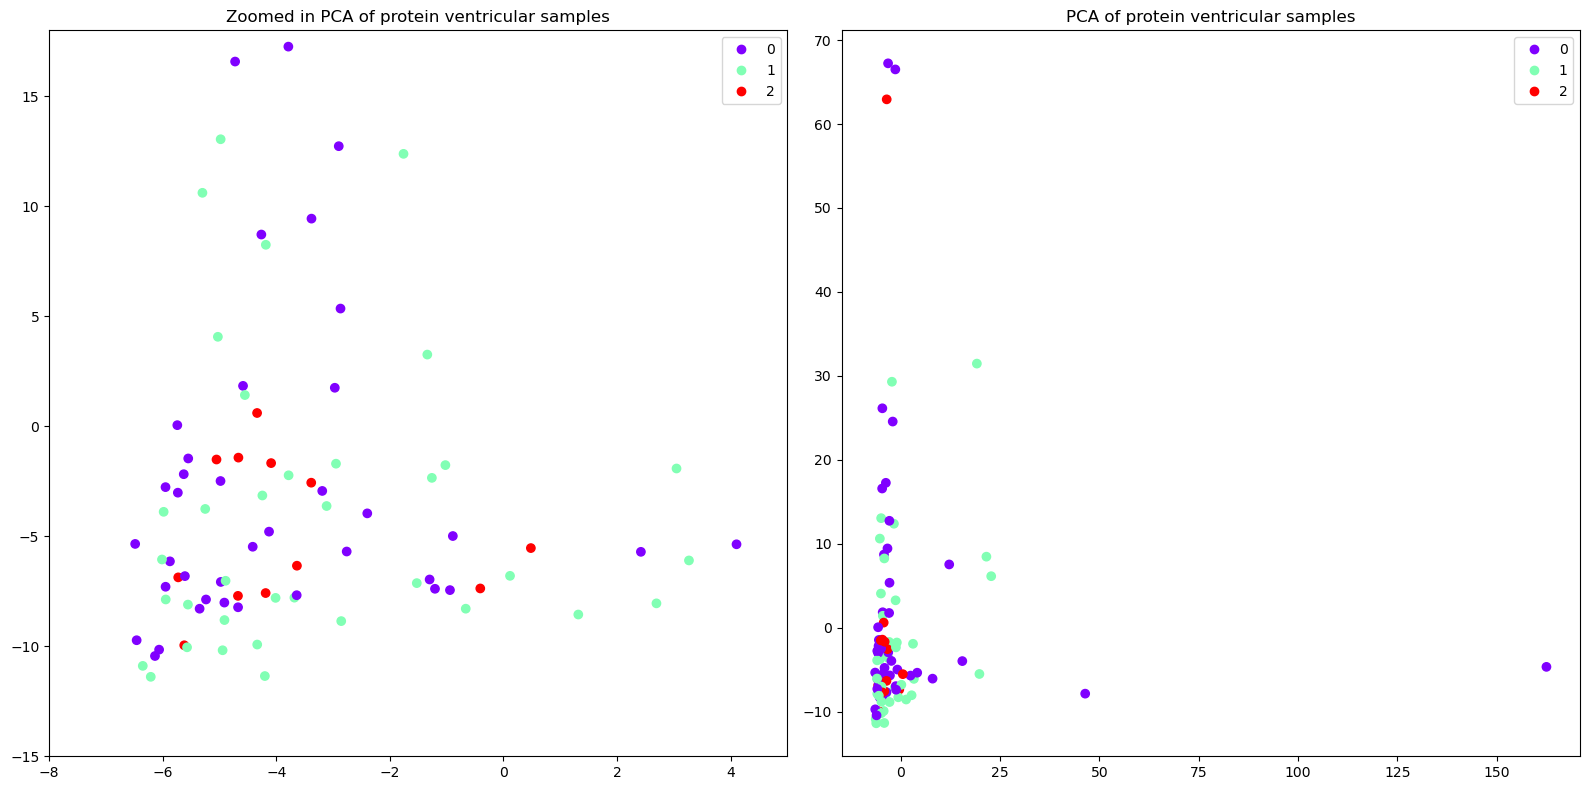

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].scatter(pca_ventricular[:,0], pca_ventricular[:,1], c=df_proteins_all[df_proteins_all['CSF_type'] == 'V']["Cortical_biopsy_grouping"], cmap="rainbow")
handles_0, _ = axs[0].collections[0].legend_elements()
labels_0 = set(df_proteins_all[df_proteins_all['CSF_type'] == 'V']["Cortical_biopsy_grouping"])
axs[0].legend(handles=handles_0, labels=labels_0)
axs[0].set_xlim(-8, 5)
axs[0].set_ylim(-15, 18)
axs[0].set_title('Zoomed in PCA of protein ventricular samples')

axs[1].scatter(pca_ventricular[:,0], pca_ventricular[:,1], c=df_proteins_all[df_proteins_all['CSF_type'] == 'V']["Cortical_biopsy_grouping"], cmap="rainbow")
handles_1, _ = axs[1].collections[0].legend_elements()
labels_1 = set(df_proteins_all[df_proteins_all['CSF_type'] == 'V']["Cortical_biopsy_grouping"])
axs[1].legend(handles=handles_1, labels=labels_1)
axs[1].set_title('PCA of protein ventricular samples')

plt.tight_layout()
plt.show()

Despite the warped nature of the scatterplot to the left, we can see that category 2 is fairly compacted compared to the other 2 categories.

### PCA - (Zero Imputation)

In [29]:
#Replacing all missing values through zero-imputation.
zero_protein_median_df = df_proteins_median_all.copy(deep=True)
zero_protein_median_df = replace_nan_with_zero(zero_protein_median_df)
zero_protein_df = df_proteins_all.copy(deep=True)
zero_protein_df = replace_nan_with_zero(zero_protein_df)

zero_peptide_median_df = df_peptides_median_all.copy(deep=True)
zero_peptide_median_df = replace_nan_with_zero(zero_peptide_median_df)
zero_peptide_df = df_peptides_all.copy(deep=True)
zero_peptide_df = replace_nan_with_zero(zero_peptide_df)

#### Median

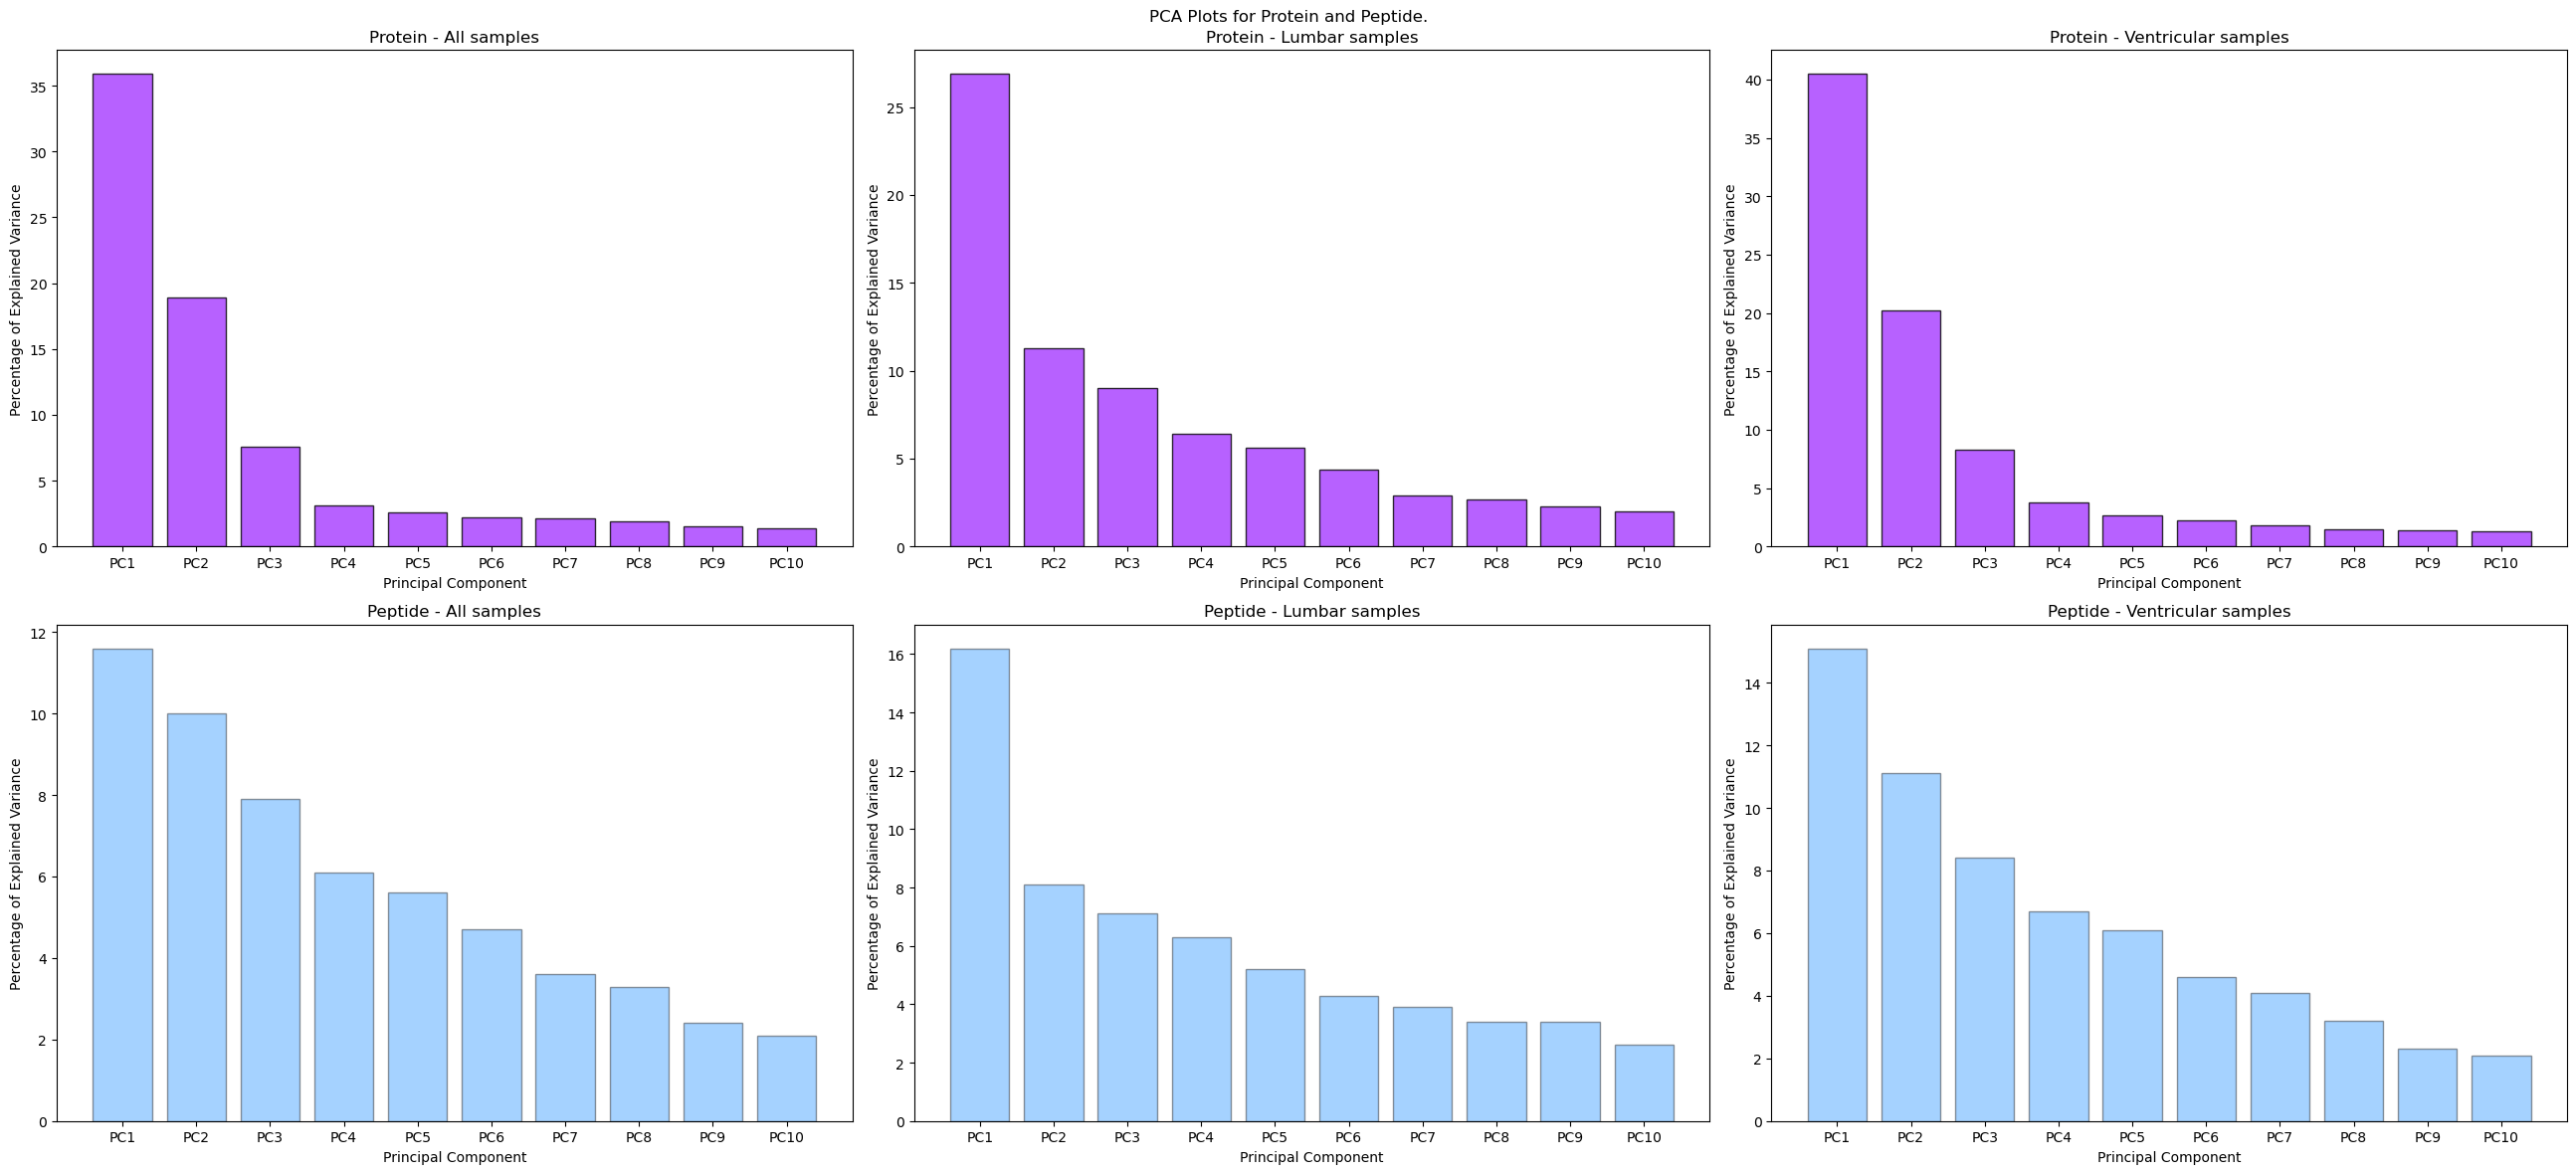

In [30]:
#--- RUNNING PCA CALCULATION AND PLOTTING ---#
datasets_protein = [zero_protein_median_df.iloc[:, 11:], zero_protein_median_df[zero_protein_median_df['CSF_type'] == 'L'].iloc[:, 11:],
                    zero_protein_median_df[zero_protein_median_df['CSF_type'] == 'V'].iloc[:, 11:]]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [zero_peptide_median_df.iloc[:, 11:], zero_peptide_median_df[zero_peptide_median_df['CSF_type'] == 'L'].iloc[:, 11:],
                     zero_peptide_median_df[zero_peptide_median_df['CSF_type'] == 'V'].iloc[:, 11:]]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_scree_plot_data(do_PCA_on_DF(dataset_protein))
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_scree_plot_data(do_PCA_on_DF(dataset_peptide))
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

When imputing with zero when missing data is found, the PCA's are even worse than when removing the data. 

#### Non Normalized

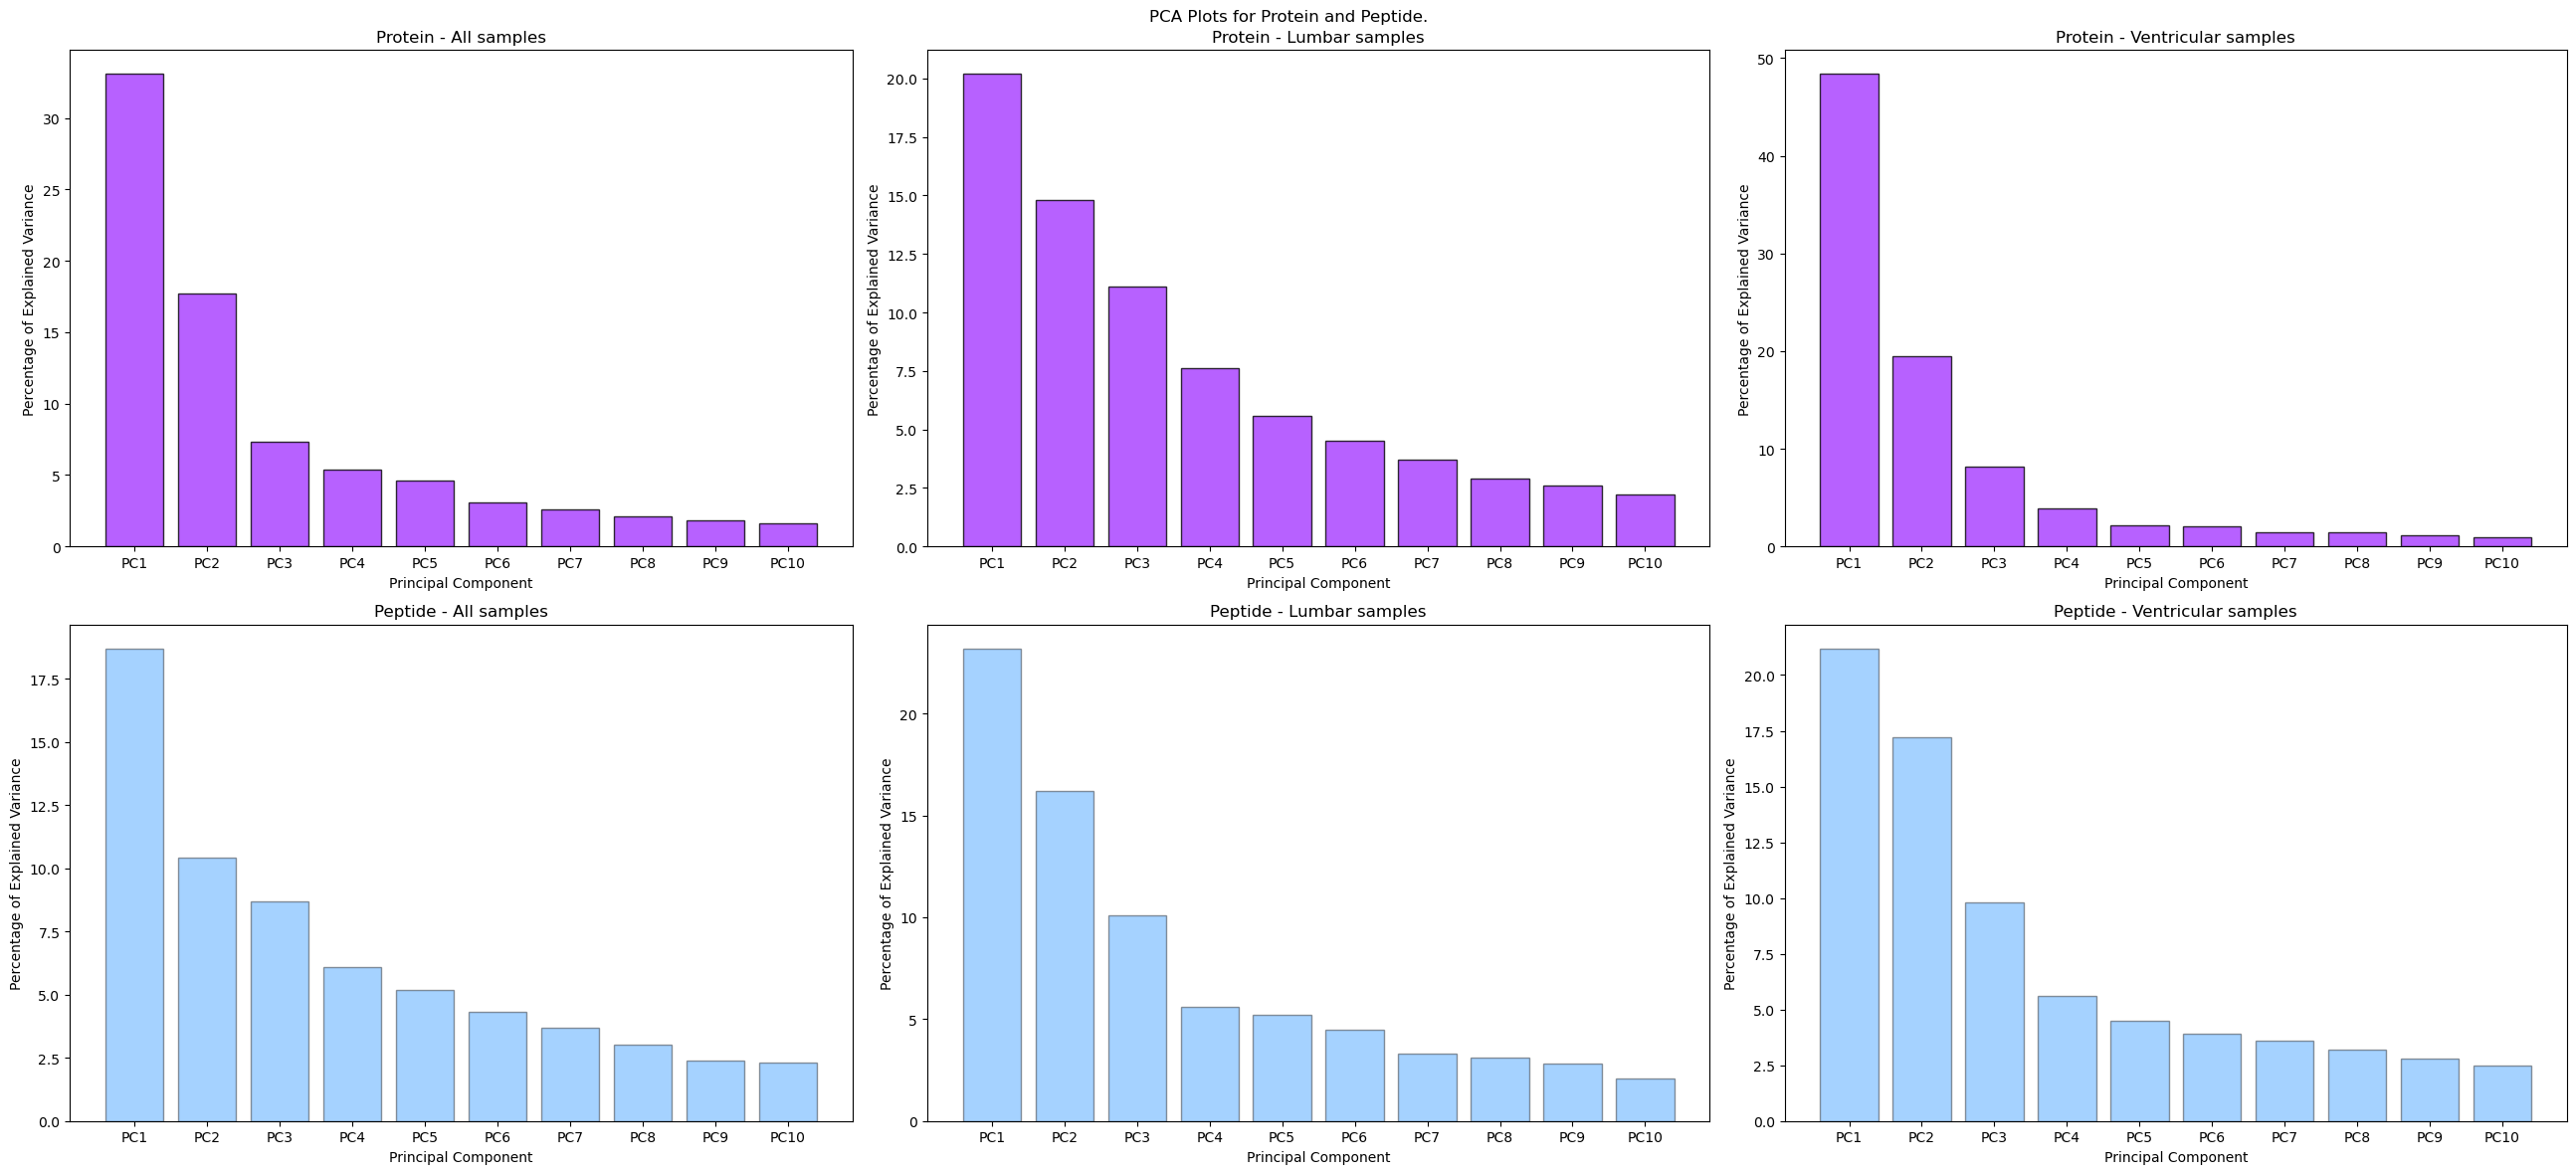

In [31]:
#--- RUNNING PCA CALCULATION AND PLOTTING ---#
datasets_protein = [zero_protein_df.iloc[:, 11:], zero_protein_df[zero_protein_df['CSF_type'] == 'L'].iloc[:, 11:],
                    zero_protein_df[zero_protein_df['CSF_type'] == 'V'].iloc[:, 11:]]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [zero_peptide_df.iloc[:, 11:], zero_peptide_df[zero_peptide_df['CSF_type'] == 'L'].iloc[:, 11:],
                     zero_peptide_df[zero_peptide_df['CSF_type'] == 'V'].iloc[:, 11:]]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_scree_plot_data(do_PCA_on_DF(dataset_protein))
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_scree_plot_data(do_PCA_on_DF(dataset_peptide))
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

### t-SNE - (No Missingness)

#### Cortical_biopsy_grouping

In [32]:
def do_tSNE_on_DF(df, feature, lr=100, n_components=2):
    """
    Gets t-SNE data from DF.

    :param df: Dataframe to perform t-SNE on.
    :param lr: Learning rate of TSNE calculation.
    :param n_components: Number of t-SNE components to find.
    :return: t-SNE results in DF.
    """ 
    df_clean = set_max_missingness_per_column(df.iloc[:,11:], 0)
    scaler = StandardScaler()
    df_tsne = scaler.fit_transform(df_clean)
    tsne = TSNE(learning_rate=lr, n_components=n_components, random_state=42)
    tsne_features = tsne.fit_transform(df_tsne)

    df_done = pd.DataFrame({'x':tsne_features[:,0], 'y':tsne_features[:,1], feature: df[feature]})
    df_done = df_done.sort_values(by=feature)
    return df_done

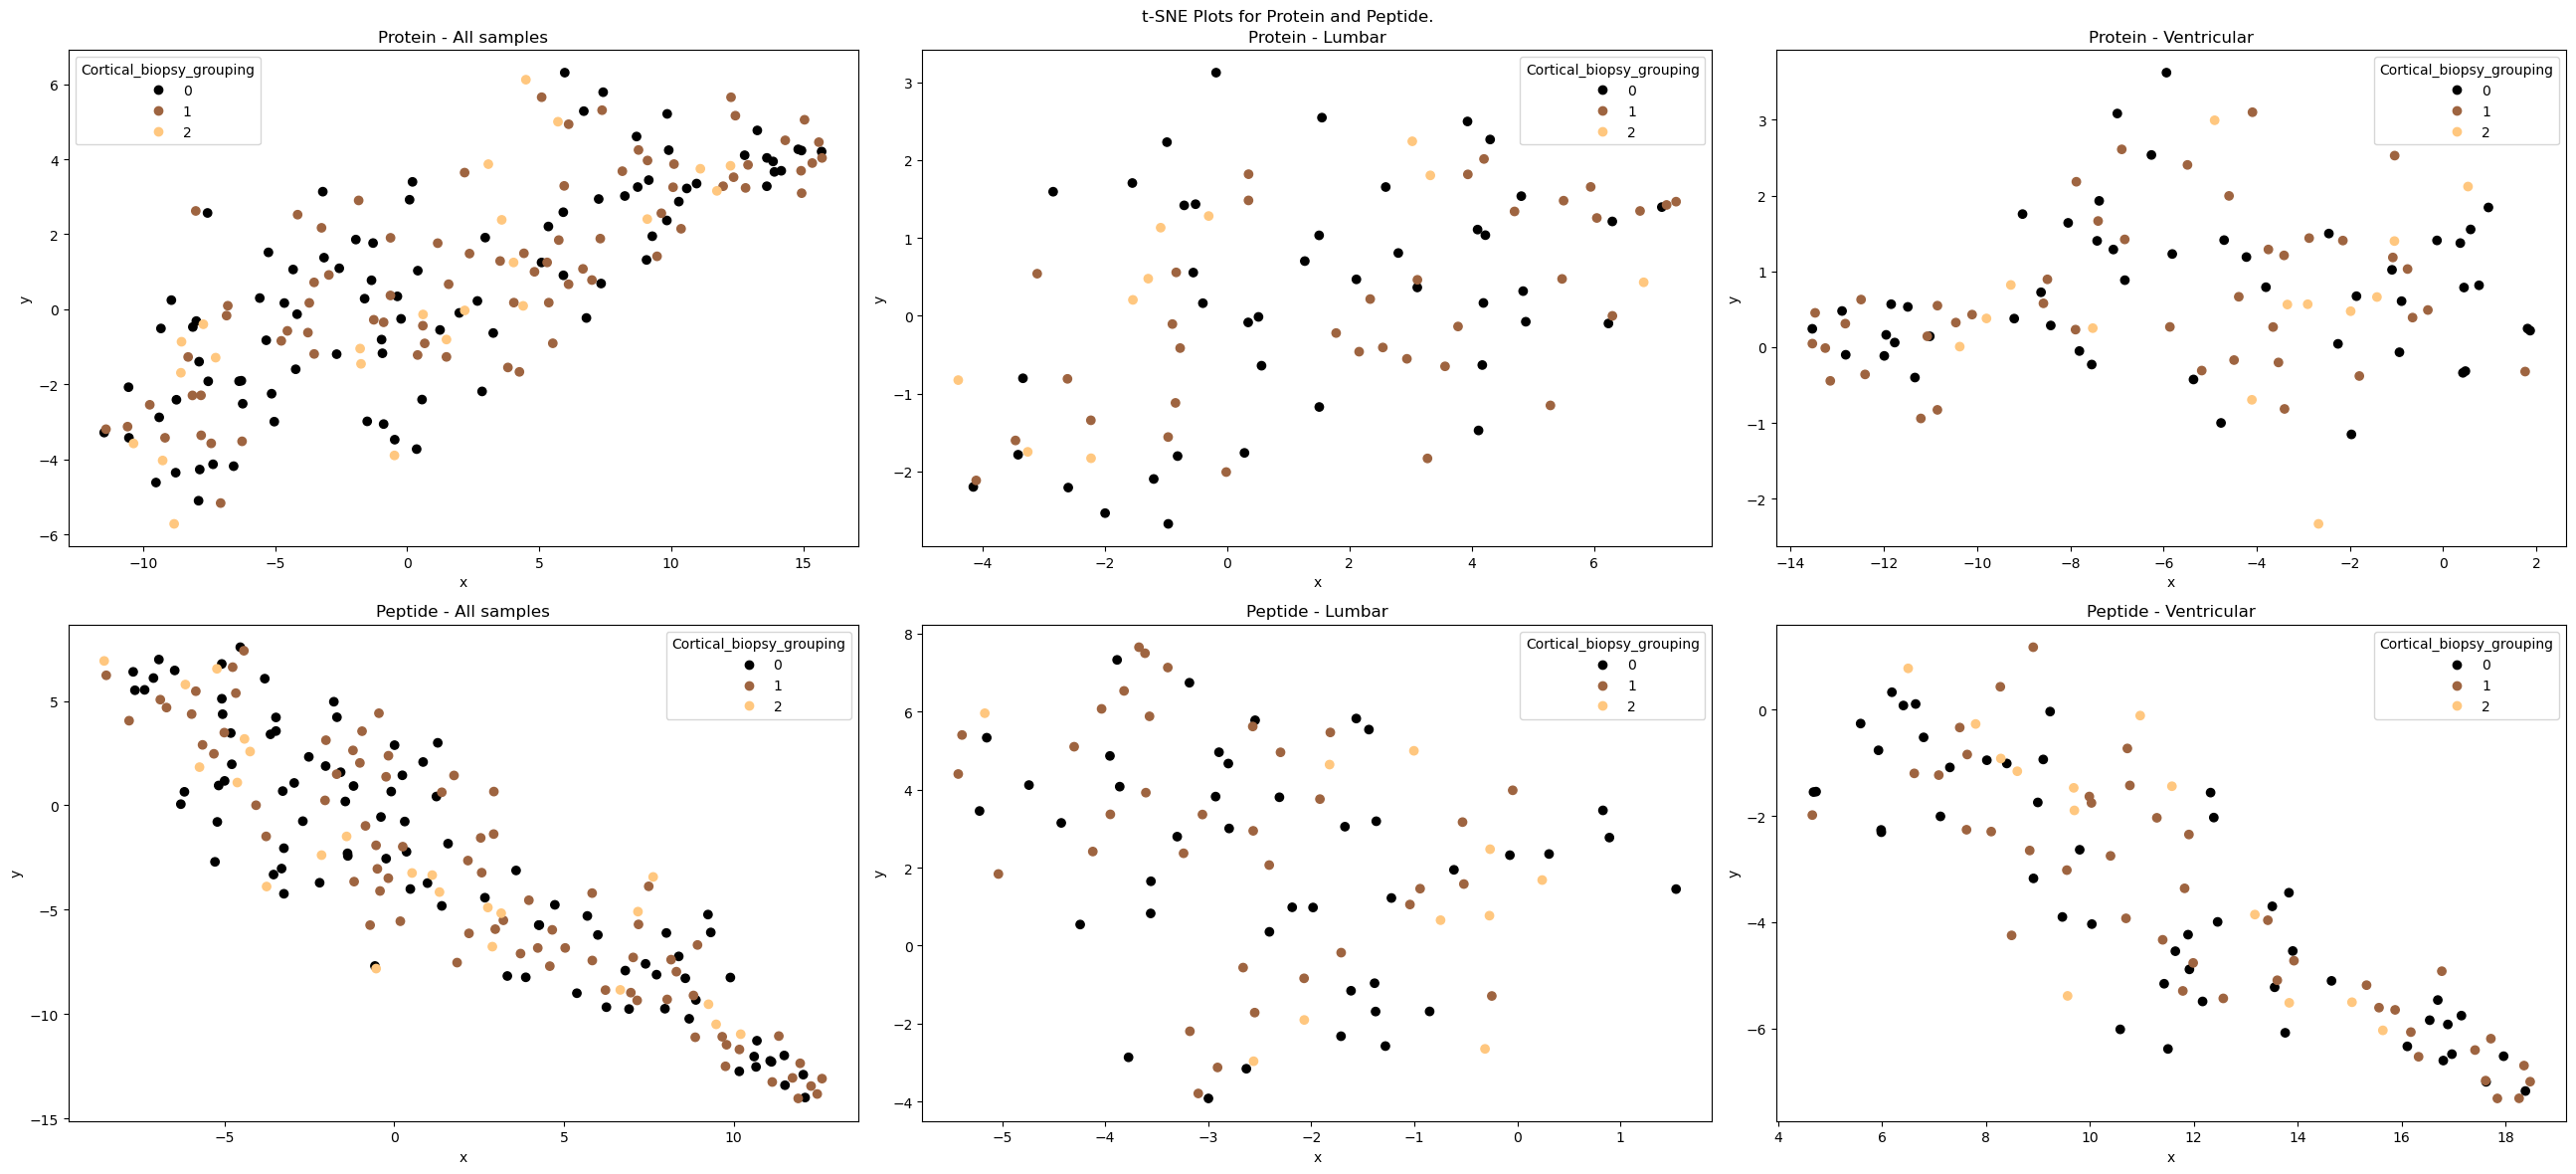

In [33]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(df_proteins_all,"Cortical_biopsy_grouping")
all_pep_result_df = do_tSNE_on_DF(df_peptides_all,"Cortical_biopsy_grouping")
l_pro_result_df = do_tSNE_on_DF(df_proteins_all[df_proteins_all['CSF_type'] == 'L'],"Cortical_biopsy_grouping")
l_pep_result_df = do_tSNE_on_DF(df_peptides_all[df_peptides_all['CSF_type'] == 'L'],"Cortical_biopsy_grouping")
v_pro_result_df = do_tSNE_on_DF(df_proteins_all[df_proteins_all['CSF_type'] == 'V'],"Cortical_biopsy_grouping")
v_pep_result_df = do_tSNE_on_DF(df_peptides_all[df_peptides_all['CSF_type'] == 'V'],"Cortical_biopsy_grouping")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["Cortical_biopsy_grouping"])
    legend_labels_protein = protein_df["Cortical_biopsy_grouping"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='Cortical_biopsy_grouping')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["Cortical_biopsy_grouping"])
    legend_labels_peptide = peptide_df["Cortical_biopsy_grouping"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='Cortical_biopsy_grouping')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

This further shows that there is no real correlation in order to classify the data based on only 2 dimensions. This seems to be true for all sample-sets (all, lumbar, ventricular).

#### TMT Set

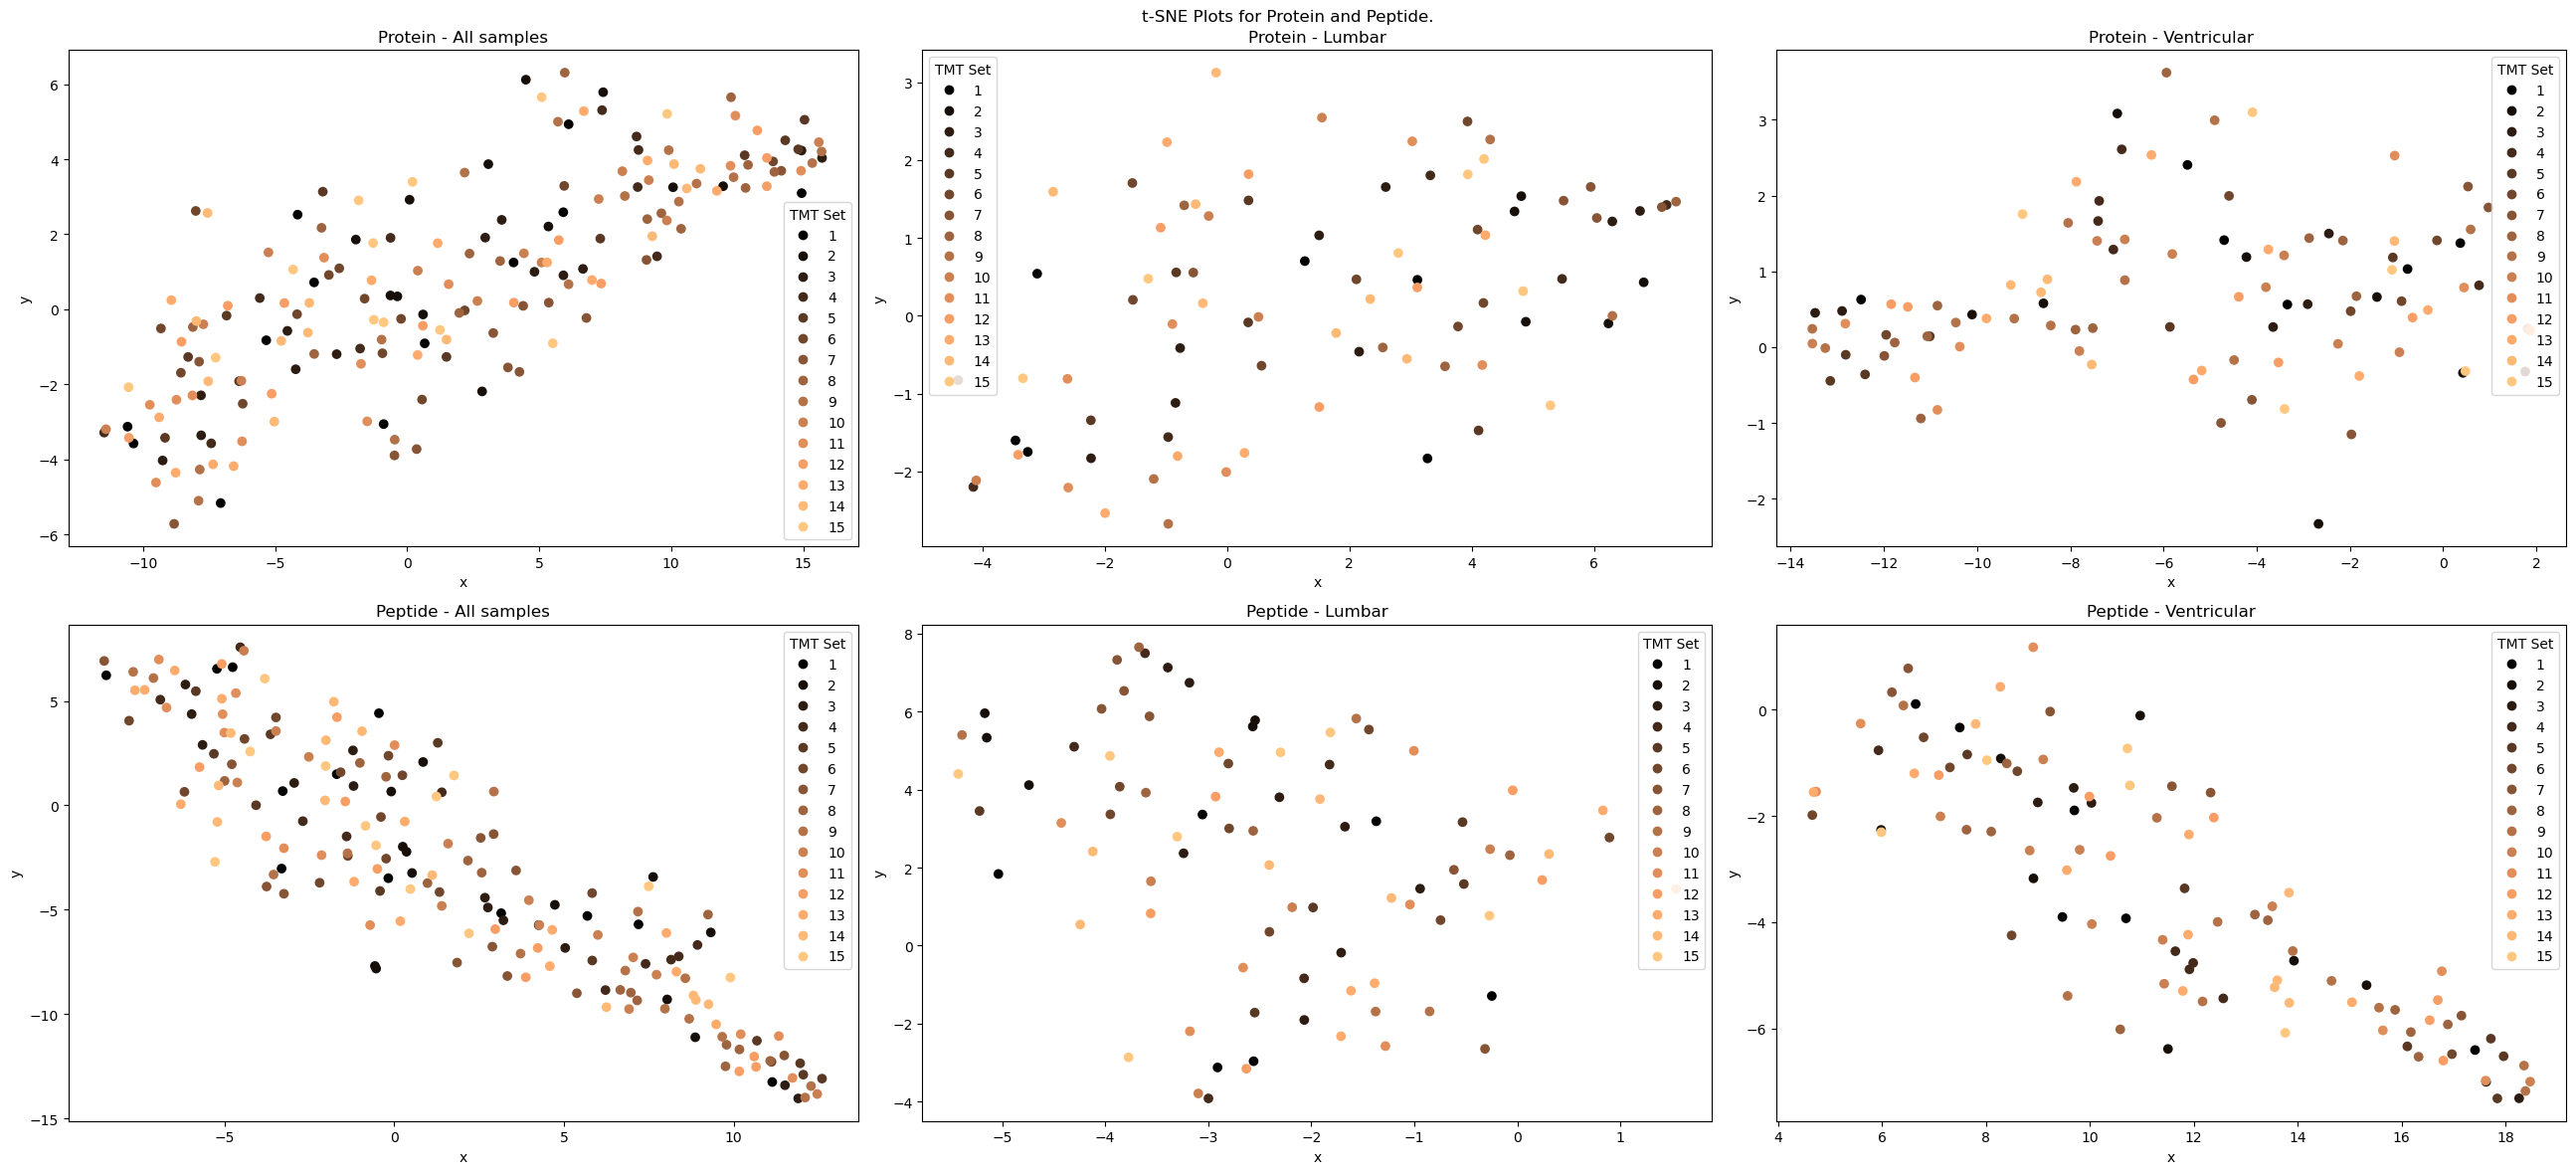

In [34]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(df_proteins_all,"TMT Set")
all_pep_result_df = do_tSNE_on_DF(df_peptides_all,"TMT Set")
l_pro_result_df = do_tSNE_on_DF(df_proteins_all[df_proteins_all['CSF_type'] == 'L'],"TMT Set")
l_pep_result_df = do_tSNE_on_DF(df_peptides_all[df_peptides_all['CSF_type'] == 'L'],"TMT Set")
v_pro_result_df = do_tSNE_on_DF(df_proteins_all[df_proteins_all['CSF_type'] == 'V'],"TMT Set")
v_pep_result_df = do_tSNE_on_DF(df_peptides_all[df_peptides_all['CSF_type'] == 'V'],"TMT Set")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["TMT Set"])
    legend_labels_protein = protein_df["TMT Set"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='TMT Set')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["TMT Set"])
    legend_labels_peptide = peptide_df["TMT Set"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='TMT Set')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

This further shows that there is no real correlation between the TMT Sets when looking at only 2 dimensions on data where missingness features are removed. In one way, this is good because it shows that there is no real batch effect when removing these features. As can be seen further down, this does not hold true when imputing missingness with zero.

### t-SNE - (Zero Imputation)

#### Cortical_biopsy_grouping

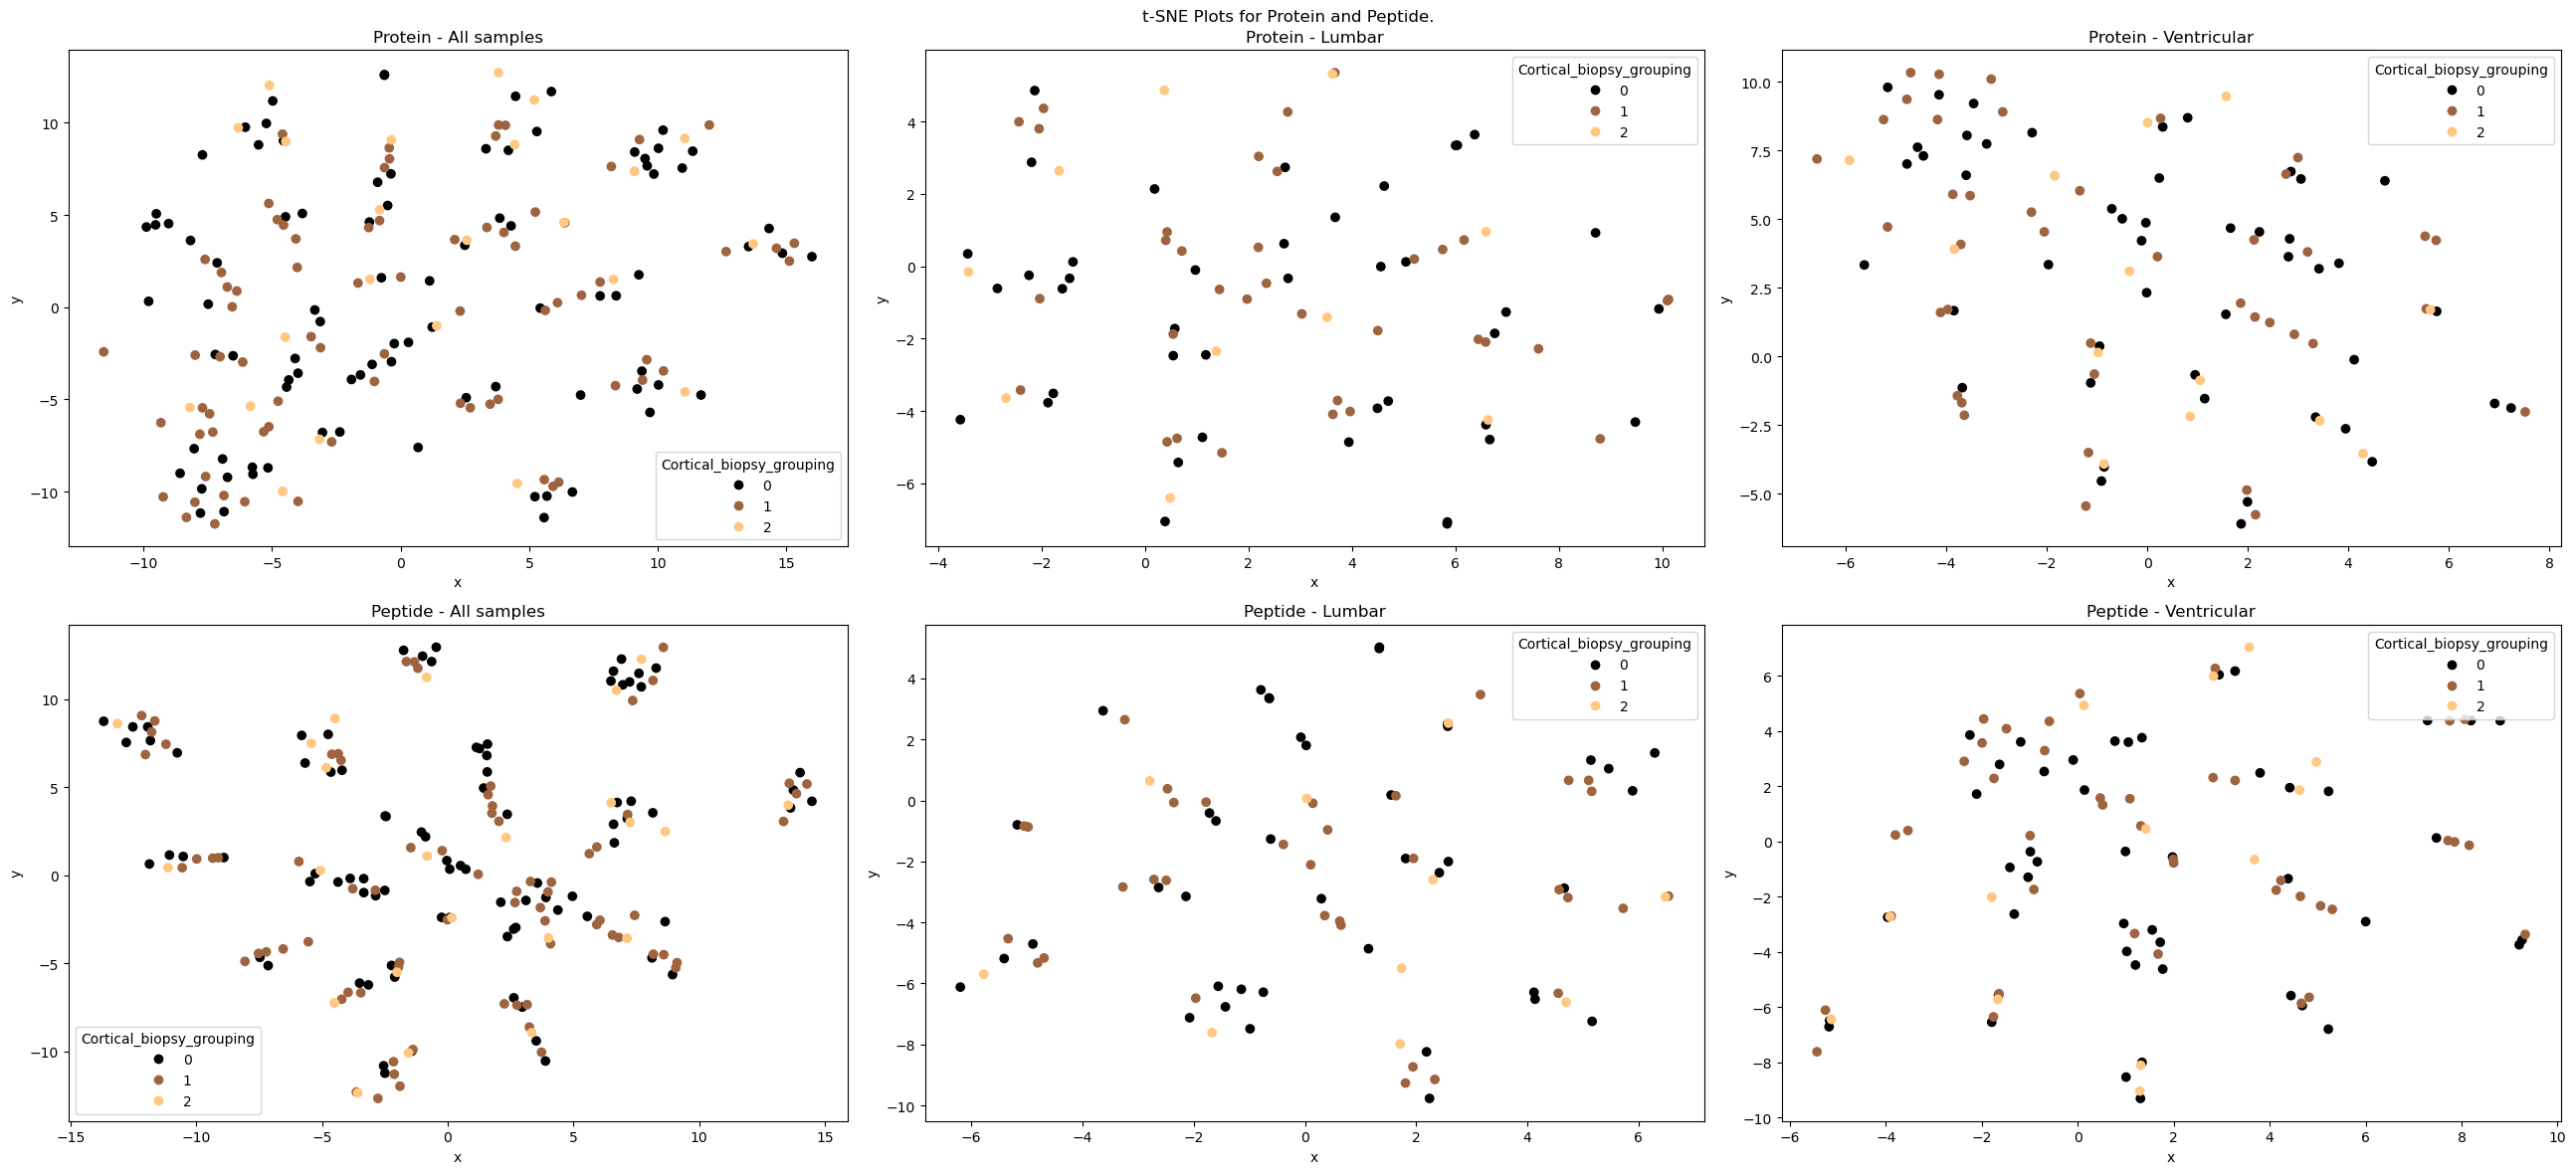

In [35]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(zero_protein_df, "Cortical_biopsy_grouping")
all_pep_result_df = do_tSNE_on_DF(zero_peptide_df, "Cortical_biopsy_grouping")
l_pro_result_df = do_tSNE_on_DF(zero_protein_df[zero_protein_df['CSF_type'] == 'L'], "Cortical_biopsy_grouping")
l_pep_result_df = do_tSNE_on_DF(zero_peptide_df[zero_peptide_df['CSF_type'] == 'L'], "Cortical_biopsy_grouping")
v_pro_result_df = do_tSNE_on_DF(zero_protein_df[zero_protein_df['CSF_type'] == 'V'], "Cortical_biopsy_grouping")
v_pep_result_df = do_tSNE_on_DF(zero_peptide_df[zero_peptide_df['CSF_type'] == 'V'], "Cortical_biopsy_grouping")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["Cortical_biopsy_grouping"])
    legend_labels_protein = protein_df["Cortical_biopsy_grouping"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='Cortical_biopsy_grouping')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["Cortical_biopsy_grouping"])
    legend_labels_peptide = peptide_df["Cortical_biopsy_grouping"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='Cortical_biopsy_grouping')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

WHen doing t-SNE on the datasets with zero imputation, we can definatly see groupings a lot more clearly compared to removing missingness features. However, when it comes to classifying the groups according to Cortical_biopsy_grouping (0 = No pathology, 1 = Only Abeta pathology, 2 = Both Abeta and tau pathology), there is no real correlation.

#### TMT Set

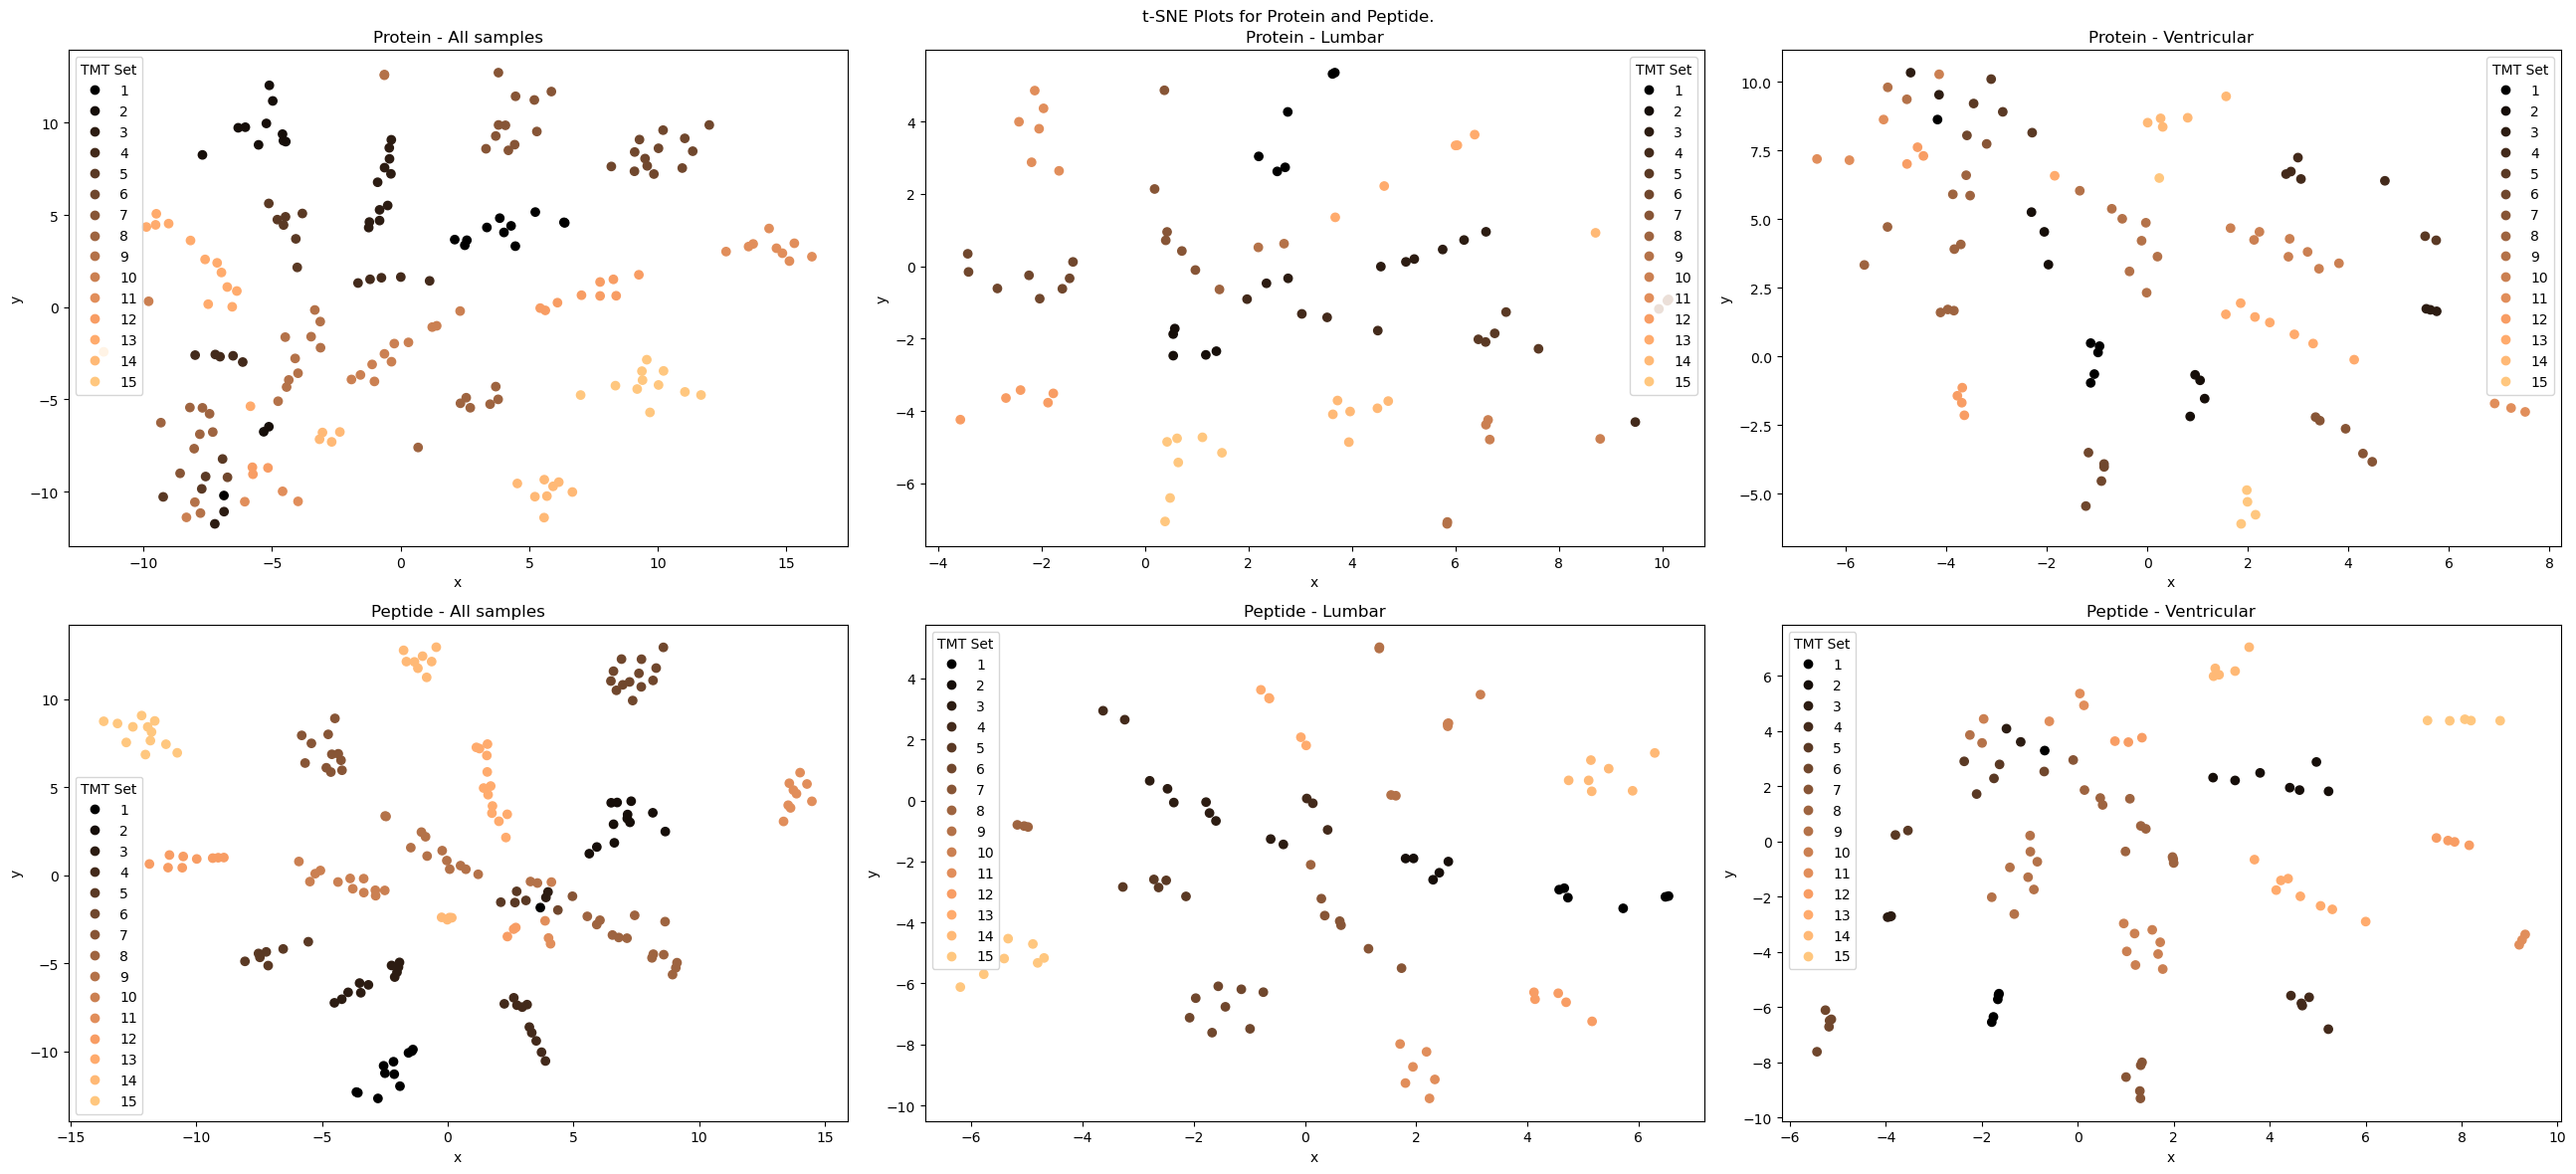

In [36]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(zero_protein_df,"TMT Set")
all_pep_result_df = do_tSNE_on_DF(zero_peptide_df,"TMT Set")
l_pro_result_df = do_tSNE_on_DF(zero_protein_df[zero_protein_df['CSF_type'] == 'L'],"TMT Set")
l_pep_result_df = do_tSNE_on_DF(zero_peptide_df[zero_peptide_df['CSF_type'] == 'L'],"TMT Set")
v_pro_result_df = do_tSNE_on_DF(zero_protein_df[zero_protein_df['CSF_type'] == 'V'],"TMT Set")
v_pep_result_df = do_tSNE_on_DF(zero_peptide_df[zero_peptide_df['CSF_type'] == 'V'],"TMT Set")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["TMT Set"])
    legend_labels_protein = protein_df["TMT Set"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='TMT Set')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["TMT Set"])
    legend_labels_peptide = peptide_df["TMT Set"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='TMT Set')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

When looking at the TMT Sets based on the datasets with zero imputation, we can see a very clear correlation between TMT Set and grouping with t-SNE. This suggest a heavy correlation, and is a sign of batch effect. This makes sense, as the different TMT Sets most likely have different proteins and peptides that have only 0 values (from the imputation), which easily distinguishes them from the other sets. The goal would be to find a imputation method that removes as few features as possible, and stil results in as much entrophy as possible, as that would mean that the batch effect has been removed efficiently. Further on, if features have to be removed (in case of high missingness), a zero imputation t-SNE should be compared to a "good imputation" t-SNE on the same sup-dataset, in order to determine if enough batch effect has been removed.

## Feature Importance

### Code

In [37]:
def random_forest_feature_extraction(df, y, num_runs = 100, num_trees = 100):
    """
    Extracts features through random forest from a df.

    :param df: Dataframe to extract features from.
    :param y: Predictor class in dataframe.
    :param num_runs: Number of iterations to create a random forest classifier.
    :param num_trees: Hyperparameter setting for each random forest classifier.
    :return: The features extracted in a pandas series.
    """ 
    X = set_max_missingness_per_column(df.iloc[:,11:], 0)
    y = df[y]

    all_feature_importances_list = [0] * len(X.columns)

    for run in range(num_runs):
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.25)
        rf_classifier = RandomForestClassifier(n_estimators=num_trees, random_state=run)
        rf_classifier.fit(X_train, y_train)
        all_feature_importances_list = [x+y for x,y in zip(all_feature_importances_list, rf_classifier.feature_importances_)]

    feature_importances_series = pd.Series(all_feature_importances_list, index=X.columns)
    feature_importances_series /= 100
    feature_importances_series = feature_importances_series.sort_values(ascending=False)
    
    return feature_importances_series

In [119]:
def visualize_top_features(importances1, importances2=None, top_n=10, samples="All samples"):
    """
    Visualize feature importance in barchart(s) from pandas series.

    :param importances1: Pandas series with feature importances.
    :param importances2: Pandas series with feature importances.
    :param top_n: How many features that should be visualized.
    """ 
    if importances2 is not None:
        top_features1 = importances1.head(top_n)
        top_features2 = importances2.head(top_n)

        fig, axes = plt.subplots(1, 2, figsize=(20, (top_n/4)))

        axes[0].barh(top_features1.index, top_features1.values)
        axes[0].set_xlabel('Importance')
        axes[0].set_title(f'Top {top_n} Feature Importance - Protein - {samples}')

        axes[1].barh(top_features2.index, top_features2.values)
        axes[1].set_xlabel('Importance')
        axes[1].set_title(f'Top {top_n} Feature Importance - Peptide - {samples}')

        plt.tight_layout()
        plt.show()

    else:
        top_features = importances1.head(top_n)

        plt.figure(figsize=(10, top_n/5))
        plt.barh(top_features.index, top_features.values)
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Feature Importance - {samples}')
        plt.show()

In [149]:
def xgb_feature_extraction(X, y, num_runs = 100):
    """
    Extracts features through XGBoost classifier from a df.

    :param df: Dataframe to extract features from.
    :param y: Predictor class in dataframe.
    :param num_runs: Number of iterations to create a XGBoost classifier.
    :return: The features extracted in a pandas series.
    """ 

    all_feature_importances_list = [0] * len(X.columns)

    for run in range(num_runs):
        X_train, _, y_train, _ = train_test_split(X, y, test_size=0.25)
        model = xgb.XGBClassifier()
        model.fit(X_train, y_train)

        all_feature_importances_list = [x+y for x,y in zip(all_feature_importances_list, model.feature_importances_)]

    feature_importances_series = pd.Series(all_feature_importances_list, index=X.columns)
    feature_importances_series /= 100
    feature_importances_series = feature_importances_series.sort_values(ascending=False)
    
    return feature_importances_series

### Random Forest - (No missingness)

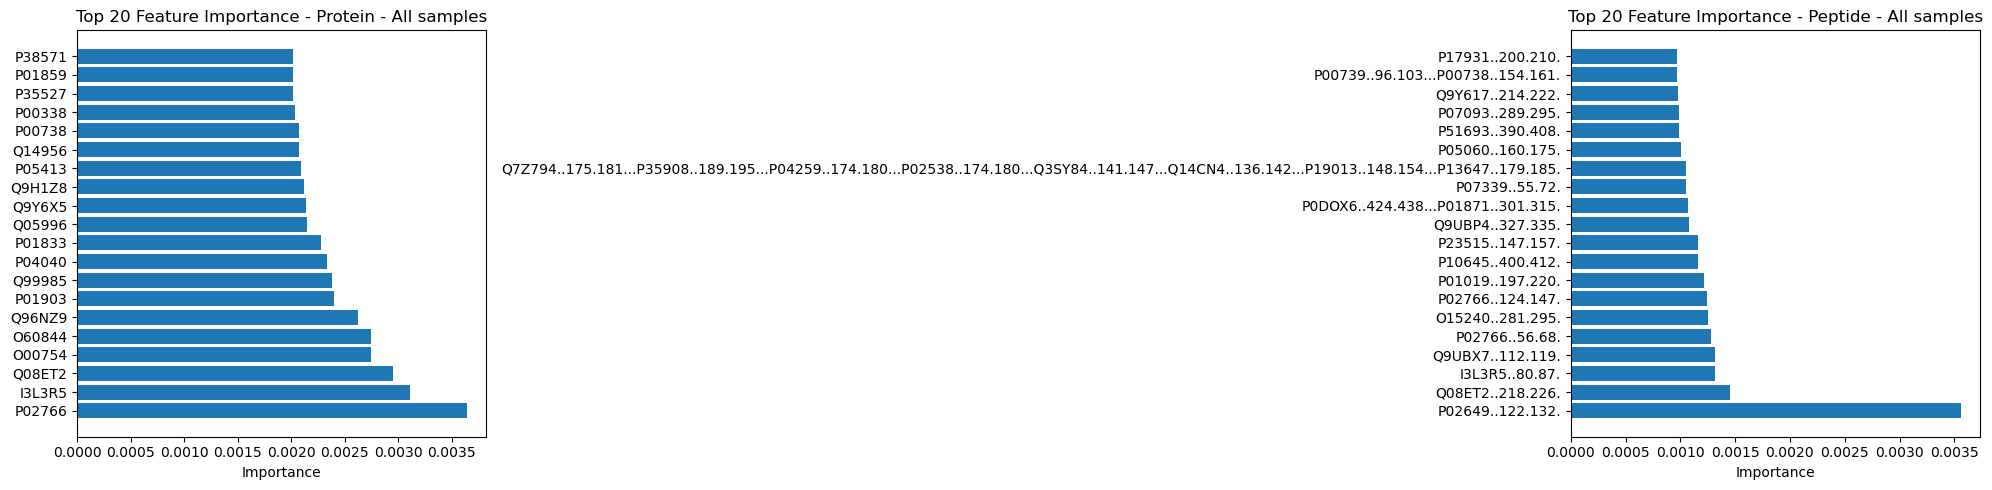

In [39]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - ALL SAMPLES ---#
protein_features_all = random_forest_feature_extraction(df_proteins_all, "Cortical_biopsy_grouping", 100)
peptide_features_all = random_forest_feature_extraction(df_peptides_all, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_all, peptide_features_all, 20)

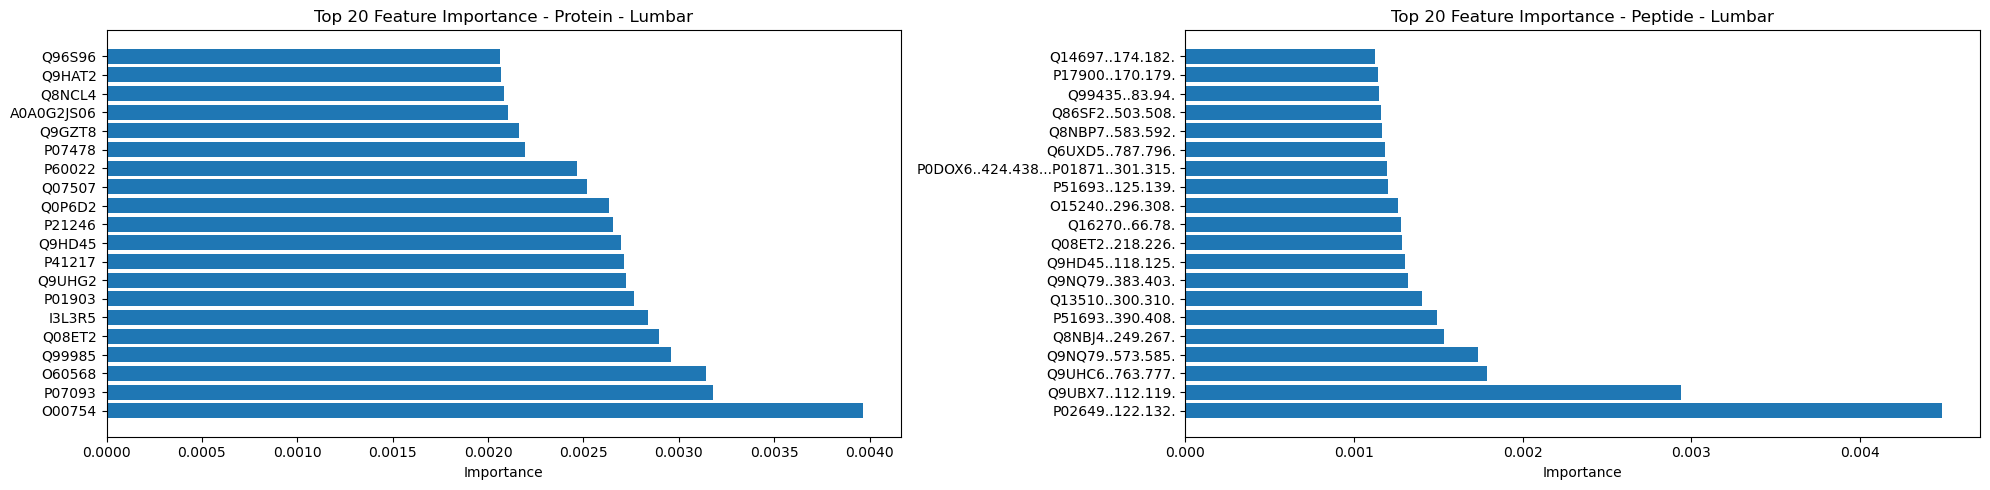

In [40]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - LUMBAR ---#
protein_features_l = random_forest_feature_extraction(df_proteins_all[df_proteins_all['CSF_type'] == 'L'], "Cortical_biopsy_grouping", 100)
peptide_features_l = random_forest_feature_extraction(df_peptides_all[df_peptides_all['CSF_type'] == 'L'], "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_l, peptide_features_l, 20, "Lumbar")

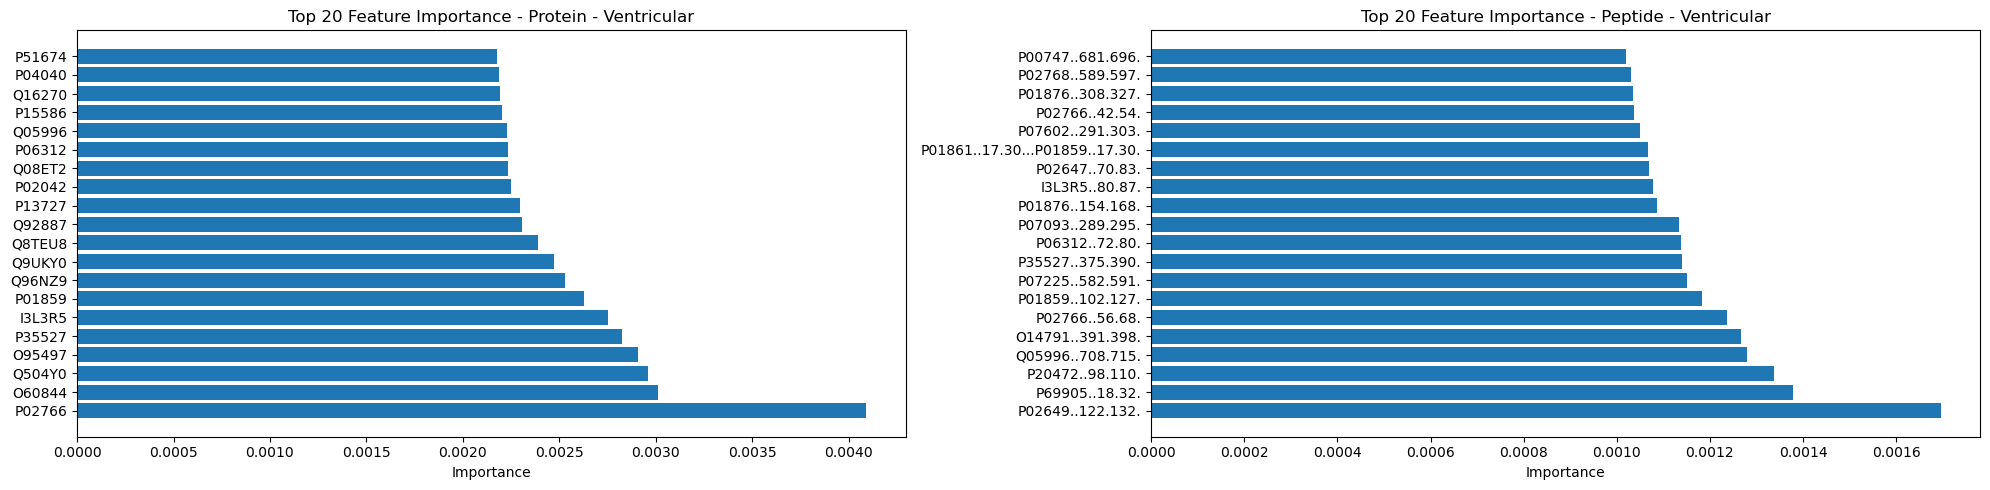

In [41]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - VENTRICULAR ---#
protein_features_v = random_forest_feature_extraction(df_proteins_all[df_proteins_all['CSF_type'] == 'V'], "Cortical_biopsy_grouping", 100)
peptide_features_v = random_forest_feature_extraction(df_peptides_all[df_peptides_all['CSF_type'] == 'V'], "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_v, peptide_features_v, 20, "Ventricular")

This is just a very simplified feature extraction through a basic random forest model. This data is based on only features without missingness, but even here, we can see that some features are strong in both samples (especially in the peptide set), while the protein set does not seem to have any common proteins in the top 20 proteins from the lumbar and ventricular set. The all samples set, however, contains proteins from both the top lumbar and ventricular set, suggesting that even if they are not in the top 20, they do exist. This is more of a proof of concept rather than "finding the best features", and hints that, especially when looking at proteins, there are different proteins that should be looked at depending on if it is a lumbar sample or a ventricular sample.

### Random Forest - (Zero imputation)

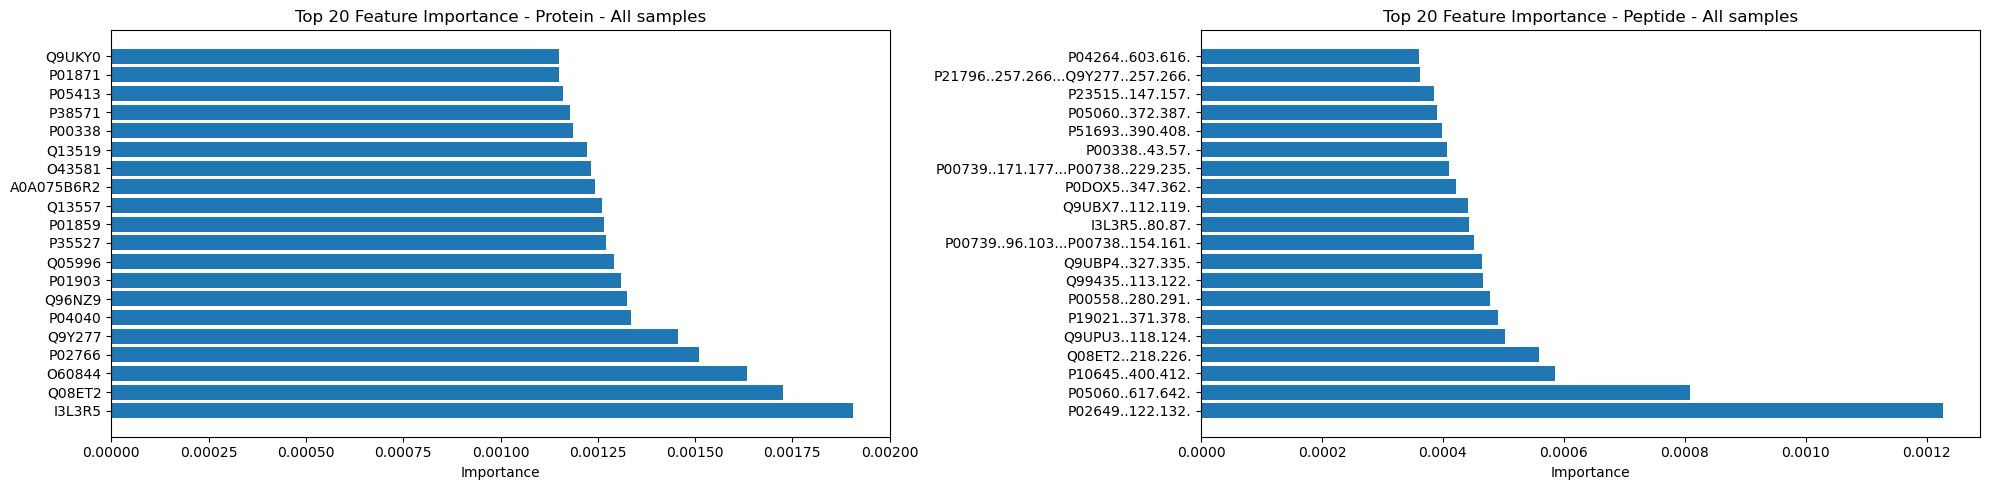

In [42]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - ALL SAMPLES ---#
protein_features_all_0 = random_forest_feature_extraction(zero_protein_df, "Cortical_biopsy_grouping", 100)
peptide_features_all_0 = random_forest_feature_extraction(zero_peptide_df, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_all_0, peptide_features_all_0, 20)

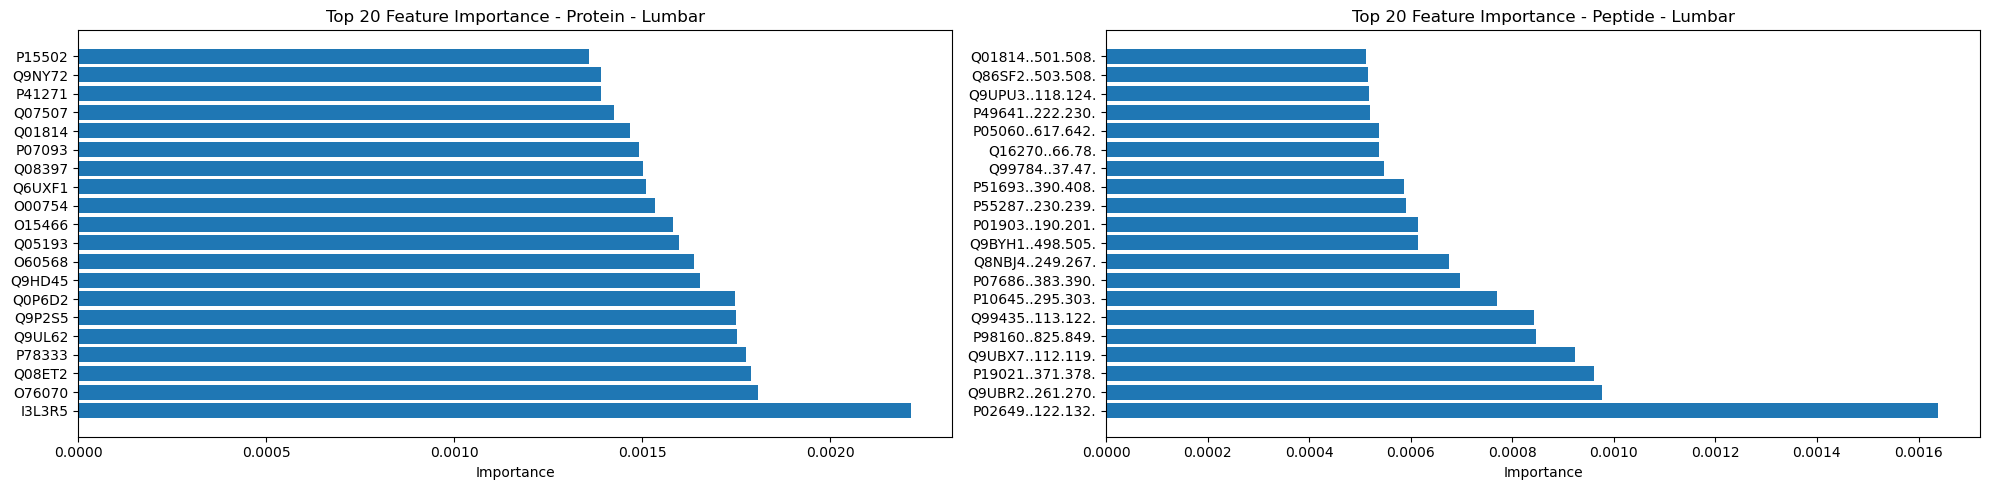

In [43]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - LUMBAR ---#
protein_features_l_0 = random_forest_feature_extraction(zero_protein_df[zero_protein_df['CSF_type'] == 'L'], "Cortical_biopsy_grouping", 100)
peptide_features_l_0 = random_forest_feature_extraction(zero_peptide_df[zero_peptide_df['CSF_type'] == 'L'], "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_l_0, peptide_features_l_0, 20, "Lumbar")

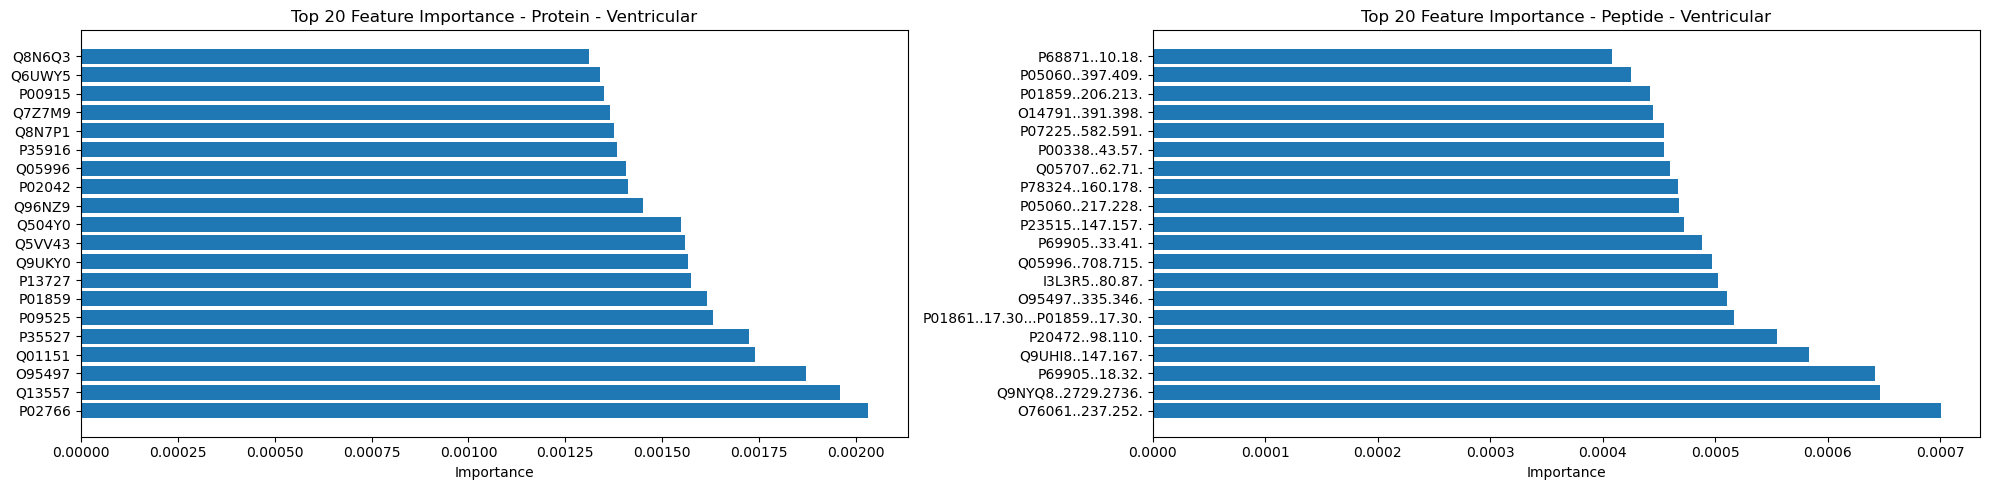

In [44]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - VENTRICULAR ---#
protein_features_v_0 = random_forest_feature_extraction(zero_protein_df[zero_protein_df['CSF_type'] == 'V'], "Cortical_biopsy_grouping", 100)
peptide_features_v_0 = random_forest_feature_extraction(zero_peptide_df[zero_peptide_df['CSF_type'] == 'V'], "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_v_0, peptide_features_v_0, 20, "Ventricular")

As with the random forest feature extraction on the datasets free from missingness, these graphs shows important features on zero imputed datasets, and the results are roughly the same. The peptide samples have slightly more in common compared to the protein datasets. The all samples show some correlation to the top 20 of the lumbar and ventricular data, but some of the proteins and peptides in the all dataset contains features not shown in the top 20.

### Lumbar & Ventricular, Feature Importance Differences - (Different Imputations)

In [45]:
def get_feature_importance_df(*args):
    """
    Creates a df based on feature importance, comparing lumbar and ventricular data.

    :param series_lumbar: Pandas series with feature importances.
    :param series_ventricular: Pandas series with feature importances.
    :param df_merged: Dataframe with feature importance of both lumbar and ventricular data.
    """     
    dfs = [pd.DataFrame({'index': series.index, series.name: series.values}) for series in args]

    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='index', how='outer')

    return merged_df

In [46]:
protein_features_l.name = 'Protein_Lumbar_NoNaN' 
protein_features_v.name = 'Protein_Ventricular_NoNaN'
protein_features_l_0.name = 'Protein_Lumbar_0'
protein_features_v_0.name = 'Protein_Ventricular_0'
feature_importance_df = get_feature_importance_df(protein_features_l, protein_features_v, protein_features_l_0, protein_features_v_0)
feature_importance_df

index  Protein_Lumbar_NoNaN  Protein_Ventricular_NoNaN  \
0     O00754              0.003967                   0.001002   
1     P07093              0.003177                   0.001129   
2     O60568              0.003140                   0.000750   
3     Q99985              0.002961                   0.000901   
4     Q08ET2              0.002898                   0.002236   
...      ...                   ...                        ...   
2790  O95837                   NaN                        NaN   
2791  P46926                   NaN                        NaN   
2792  O60512                   NaN                        NaN   
2793  P62861                   NaN                        NaN   
2794  Q9UDW1                   NaN                        NaN   

      Protein_Lumbar_0  Protein_Ventricular_0  
0             0.001534               0.000372  
1             0.001490               0.000758  
2             0.001637               0.000337  
3             0.001287               0.000495  
4             0.001789               0.000986  
...                ...                    ...  
2790          0.000000               0.000000  
2791          0.000000               0.000000  
2792          0.000000               0.000000  
2793          0.000000               0.000000  
2794          0.000000               0.000000  

[2795 rows x 5 columns]

The above code shows how the feature importance extracted from the random forest changes depending on Lumbar / Ventricular and imputation type (removing missing values vs zero-imputation). 

This can show both how the importance changes depending on imputaiton type, as well as the difference in importance depending on where the sample is taken from.

In [47]:
def get_compare_feature_importance(df, col1, col2, min_dif = 0.002000):
    """
    Find features that differ between two of the columns with more than a certain difference.

    :param df: DataFrame.
    :param col1: Column name.
    :param col2: Column name.
    :param min_dif: Minimum difference between the values of two columns.
    :return: DataFrame with all features with minimum difference.
    """
    diff_rows = []

    for index, row in df.iterrows():
        lumbar_value = row[col1]
        ventricular_value = row[col2]
        
        if abs(lumbar_value - ventricular_value) > min_dif:
            diff_rows.append(row)

    diff_df = pd.DataFrame(diff_rows)

    return diff_df

In [48]:
get_compare_feature_importance(feature_importance_df, "Protein_Lumbar_NoNaN", "Protein_Ventricular_NoNaN", 0.00200)

index  Protein_Lumbar_NoNaN  Protein_Ventricular_NoNaN  Protein_Lumbar_0  \
0   O00754              0.003967                   0.001002          0.001534   
1   P07093              0.003177                   0.001129          0.001490   
2   O60568              0.003140                   0.000750          0.001637   
3   Q99985              0.002961                   0.000901          0.001287   
9   Q9HD45              0.002698                   0.000608          0.001654   
11  Q0P6D2              0.002632                   0.000476          0.001745   
64  P02766              0.001614                   0.004093          0.000791   

    Protein_Ventricular_0  
0                0.000372  
1                0.000758  
2                0.000337  
3                0.000495  
9                0.000393  
11               0.000290  
64               0.002031

The above code shows the proteins (or peptides) that differ between Lumbar and Ventricular samples with a certain feature importance value. This shows how some features have higher importancen depending on if they are from lumpar or ventricular samples.

### Lumbar & Ventricular, Missingness Difference

In [49]:
def find_missingness_difference_between_sample(df):
    """
    Find features that differ between two of the columns with more than a certain difference.

    :param df: DataFrame.
    :return: DataFrame showing features that only exists based on another feature.
    """
    missingness_by_CSF_type = df.groupby('CSF_type').apply(lambda x: x.isnull().mean())
    mask_L = (missingness_by_CSF_type.loc['L'] == 1.0) & (missingness_by_CSF_type.loc['V'] != 1.0)
    mask_V = (missingness_by_CSF_type.loc['L'] != 1.0) & (missingness_by_CSF_type.loc['V'] == 1.0)

    print(f'Missing lumbar features: \n{missingness_by_CSF_type.columns[mask_L]} \n\nMissing ventricular features: \n{missingness_by_CSF_type.columns[mask_V]}')

In [50]:
find_missingness_difference_between_sample(df_peptides_median_all)

Missing lumbar features: 
Index(['Q9NRB3..342.360.', 'P01019..57.75.', 'P02751..1252.1286.',
       'Q14624..339.371.'],
      dtype='object') 

Missing ventricular features: 
Index(['Q9UHL4..124.143.', 'Q9ULL4..145.183.', 'Q14393..551.568.',
       'Q9UM47..1211.1220.', 'O60512..296.303.', 'Q92673..1491.1501.',
       'P06396..246.252.'],
      dtype='object')


The above code returns the features that have a 100% missingness in either Lumbar or Ventricular, but not in the other. The "Missing lumbar features" means that those peptides only have NaN values for all lumbar samples. (Note: most of these seem to appear due to a random 100+ value appearing in one or a few samples.)

In [51]:
#--- CREATING DATAFRAME BASED ON TMT SET MISSINGNESS DATA ON PROTEIN/PEPTIDE LEVEL ---#
def get_tmt_missingness_data(df_protein, df_peptide):
    """
    Get DataFrame with TMT based missingness data from protein and peptide dataset.

    :param df_protein: Protein dataframe.
    :param df_peptide: Peptide dataframe.
    :return: DataFrame with TMT based missingness data.
    """
    missing_values_per_row_pro = df_protein.iloc[:, 11:].isnull().sum(axis=1)
    missing_values_per_row_pep = df_peptide.iloc[:, 11:].isnull().sum(axis=1)

    new_df_pro = pd.DataFrame({
        'Sample_Run_ID': df_protein['Sample_Run_ID'],
        'TMT Set': df_protein['TMT Set'],
    })

    new_df_pep = pd.DataFrame({
        'missing_per_row_peptide': missing_values_per_row_pep
    })

    missing_values_df = pd.merge(new_df_pep, new_df_pro, left_index=True, right_index=True)
    missing_values_df['dif'] = (missing_values_per_row_pro / len(df_protein.iloc[0])) / (missing_values_per_row_pep / len(df_peptide.iloc[0]))
    missing_values_df = missing_values_df.sort_values("TMT Set")
    c_order = ['Sample_Run_ID', 'TMT Set', 'missing_per_row_peptide', 'dif']
    missing_values_df = missing_values_df[c_order]

    grouped_df = missing_values_df.groupby('TMT Set').agg({
        'Sample_Run_ID': list,
        'dif': 'mean',
        'missing_per_row_peptide': ['min', 'max']
    }).reset_index()

    grouped_df['inconsistent_columns_peptide'] = grouped_df['TMT Set'].apply(lambda tmt_set: find_inconsistent_columns(df_peptide[df_peptide['TMT Set'] == tmt_set].iloc[:, 11:]))
    grouped_df['n_inconsistent_peptide'] = grouped_df['inconsistent_columns_peptide'].apply(len)


    grouped_df.columns = ['_'.join(col).strip('_') for col in grouped_df.columns.values]

    return grouped_df


def find_inconsistent_columns(df):
    """
    Find columns where not all values are of the same type, considering NaN as a separate type.

    :param df: DataFrame.
    :return: List of column names where values are inconsistent in type.
    """
    inconsistent_columns = []

    for column in df.columns:
        column_values = df[column]
        unique_types = set(type(value) if not pd.isna(value) else np.nan for value in column_values)

        if len(unique_types) > 1:
            inconsistent_columns.append(column)

    return inconsistent_columns


In [52]:
tmt_data_df = get_tmt_missingness_data(df_proteins_all, df_peptides_all)
tmt_data_df

TMT Set                                 Sample_Run_ID_list  dif_mean  \
0         1             [1, 4, 10, 9, 8, 7, 11, 5, 4, 3, 2, 6]  0.759258   
1         2   [32, 73, 72, 12, 71, 51, 70, 37, 19, 50, 69, 67]  0.709072   
2         3  [74, 80, 79, 24, 29, 78, 18, 77, 76, 75, 74, 8...  0.756711   
3         4            [83, 84, 85, 42, 86, 39, 87, 88, 7, 89]  0.784739   
4         5       [91, 70, 87, 93, 63, 92, 90, 82, 65, 62, 71]  0.726420   
5         6  [94, 89, 78, 94, 53, 17, 14, 66, 95, 75, 41, 9...  0.689585   
6         7   [49, 91, 59, 44, 26, 45, 22, 79, 93, 88, 52, 97]  0.690611   
7         8  [101, 80, 99, 56, 102, 40, 43, 15, 100, 92, 69...  0.635799   
8         9  [101, 64, 5, 60, 105, 73, 61, 58, 103, 102, 10...  0.726000   
9        10  [12, 21, 20, 3, 19, 18, 22, 16, 15, 14, 13, 17...  0.696139   
10       11    [31, 30, 29, 8, 20, 28, 27, 26, 25, 24, 23, 21]  0.635831   
11       12   [38, 41, 40, 39, 37, 33, 31, 36, 35, 34, 32, 11]  0.732215   
12       13  [42, 38, 28, 43, 44, 47, 46, 45, 50, 30, 48, 4...  0.770397   
13       14   [61, 60, 59, 58, 25, 56, 55, 54, 53, 52, 51, 57]  0.759710   
14       15    [68, 67, 66, 16, 65, 46, 9, 64, 63, 62, 10, 35]  0.708066   

    missing_per_row_peptide_min  missing_per_row_peptide_max  \
0                          8150                         8151   
1                          8156                         8158   
2                          9066                         9066   
3                          8376                         8378   
4                          8842                         8842   
5                          6910                         6910   
6                          7417                         7445   
7                          7946                         7949   
8                          8955                         8955   
9                          9311                         9311   
10                         7699                         7704   
11                         7390                         7393   
12                         8718                         8722   
13                         8248                         8250   
14                         7190                         7197   

                         inconsistent_columns_peptide  n_inconsistent_peptide  
0   [O76013..173.179...P02533..195.201...P08727..1...                       1  
1                [P60201..219.229., P60201..128.137.]                       2  
2                                                  []                       0  
3   [P04264..268.277...P04259..251.260...P02538..2...                       2  
4                                                  []                       0  
5                                                  []                       0  
6   [P02533..31.41...P08779..31.41., P13647..74.84...                      31  
7   [P60201..46.53., P60201..128.137., P60201..99....                       3  
8                                                  []                       0  
9                                                  []                       0  
10  [P35527..192.199., P02533..408.416...P08727..3...                       6  
11  [P04264..417.432., P35527..225.233., P35908..3...                       3  
12  [P35908..342.353...P04259..327.338...P02538..3...                       6  
13  [P02768..118.138., P02768..222.233., P02787..6...                       3  
14  [P04259..427.436...P02538..427.436., P08779..2...                       7

(In the above graph, high dif_mean means that, comparatively, either more peptides were found or less proteins were found. The difference of dif_mean between the sets means that the ratio of found peptides / proteins differ.)

This is missingness data based on the grouping of the TMT Sets. This is a basic and overarching way of looking at the batch effect. It seems that in each TMT Set, the number of proteins discored seems to be differing by 1 value between the individuals in the set, while in the peptide set, this value is between 4 and 18. Further, there seems to be a big difference in the protein vs peptide missingness in each TMT Set. On average, the proteins have a missingness of 72% of that of the peptides in each TMT Set, but this value goes as low as 63% and as high as 78%. Following this, some TMT Sets have a lot more missingness compared to others. All of this seems to suggest that a "good TMT Set" does not necessarily result in good results for both proteins and peptides.

Furthermore, there are times where not all samples in a TMT Set receive values in all peptides (for proteins, this case always holds true). This goes against our idea of TMT and Mass Spectrometry, where all samples in a batch should get a value for each protein/peptide. However, this shows that between 3 and 55 peptides get "not all values" or "not all NaN". We propose a Batch sampling method for this.

(AS BEFORE 26/01/2024):
We noticed that some values in the peptide dataset had values in the 50's to 200's, something that seems to be way out of the norm, and is probably due to some form of error.
These values seems to correlate (after sampling a few of them) with the Inf values found early on in the protein dataset.
They also seem to only appear in TMT Set columns with both NaN values and float values, something that we though should not be possible.
Suggestions on how to fix this (any values over XX is converted to NaN, if there are NaN values in a column in a TMT Set, ALL values in the TMT sets column should be turned to NaN values) have been discussed.


### High Missingness Feature Importance

In [154]:
#--- RUNS XGBOOST FEATURE EXTRACTION ON HIGH MISSINGNESS DATASETS ---#
df_high_missingness_proteins = set_max_missingness_per_column(df_proteins_all.iloc[:, 11:], 0.8, True)
df_high_missingness_peptides = set_max_missingness_per_column(df_peptides_all.iloc[:, 11:], 0.8, True)

top_features_proteins_all = xgb_feature_extraction(df_high_missingness_proteins, df_proteins_all['Cortical_biopsy_grouping'])
top_features_peptides_all = xgb_feature_extraction(df_high_missingness_peptides, df_peptides_all['Cortical_biopsy_grouping'])

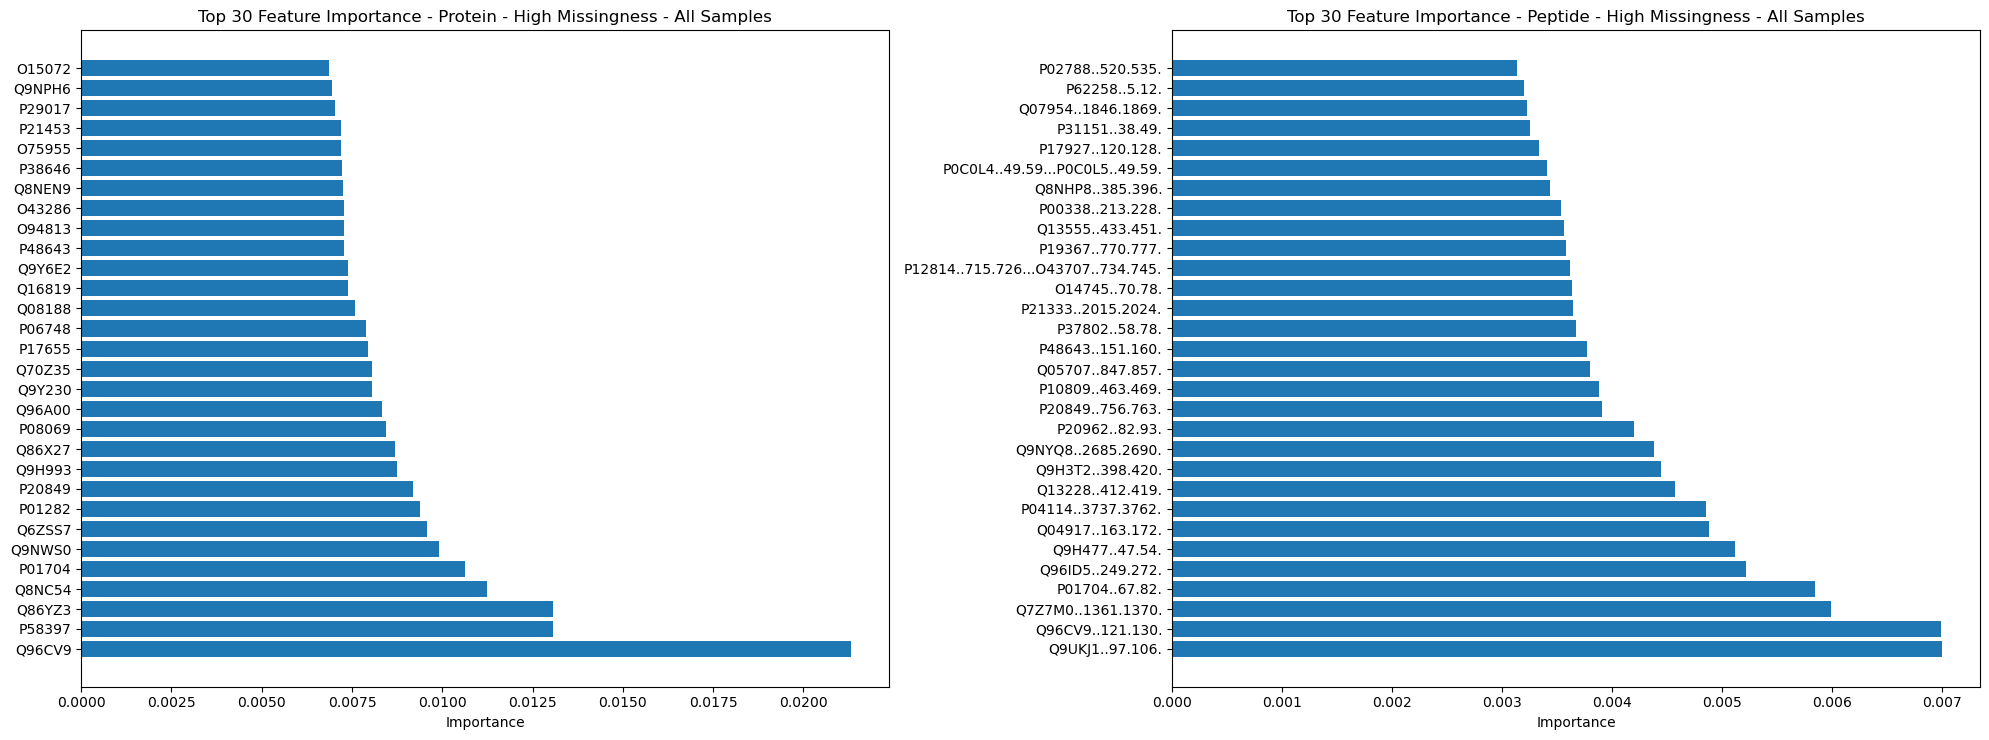

In [155]:
visualize_top_features(top_features_proteins_all, top_features_peptides_all, 30, 'High Missingness - All Samples')

# Imputation

## SimpleImpute & t-SNE

### Code

In [53]:
class SampMin(SimpleImputer):
    """
        SampMin imputation strategy. Imputes values with the lowest observed value for each column/feature.
    """
    def fit(self, X, y=None):
        X = X.dropna(axis=1, how='all')
        self.min_values = X.min() 
        return X

    def transform(self, X):
        return X.fillna(self.min_values)
    
    def fit_transform(self, X):
        X = self.fit(X)
        return self.transform(X)


In [54]:
def plot_tnses(tsne, c, title, ax):
    ax.scatter(tsne[:, 0], tsne[:,1], c=c, cmap="tab20")
    ax.set_title(title)
    ax.set_xlabel("T-SNE_1")
    ax.set_ylabel("T-SNE_2")

In [55]:
def apply_tsne(df, n_components = 2, random_state = None, perplexity = 5):
    """
    Applies T-SNE by fit_transform()

    :param df: Dataframe that's going to be fit_transformed()
    :param n_components: Threshold percentage of missingness allowed per column.
    :param random_state: Seed for random state
    :param perplexity: Sets the perplexity i.e. roughly a global/local cluster trade-off
    :return: T-SNE object
    """ 
    return TSNE(n_components=n_components, random_state=random_state, perplexity=perplexity).fit_transform(df)

In [56]:
def impute_and_plot(dfs, cs, titles):
    """
    Imputes using SimpleImputer strategies and creates T-SNE plots for each strategy.

    :param dfs: List of Dataframes to remove NaN-heavy columns from.
    :param cs: List of Threshold percentages of missingness allowed per column.
    :param titles: List of Plot titles (usually ventricular/lumbar and proteins/peptides)
    :return: None
    """ 
    imputation_methods = ["SampMin", "mean", "median", "constant"]
    num_plots = len(dfs)
    fig, axes = plt.subplots(num_plots, len(imputation_methods), figsize=(24, 4*num_plots))

    for i, df in enumerate(dfs):
        for j, method in enumerate(imputation_methods):
            ax = axes[i, j]
            if method == "SampMin":
                imputer = SampMin(strategy=method, missing_values=np.nan)
            else:
                imputer = SimpleImputer(strategy=method, missing_values=np.nan, fill_value=0)
            df_imputed = imputer.fit_transform(df)
            tsne = apply_tsne(df_imputed)
            plot_tnses(tsne, c=cs[i], title=titles[i] + " (" + method + ")", ax=ax)

    plt.tight_layout()
    plt.show()

### Imputing and plotting

#### Proteins

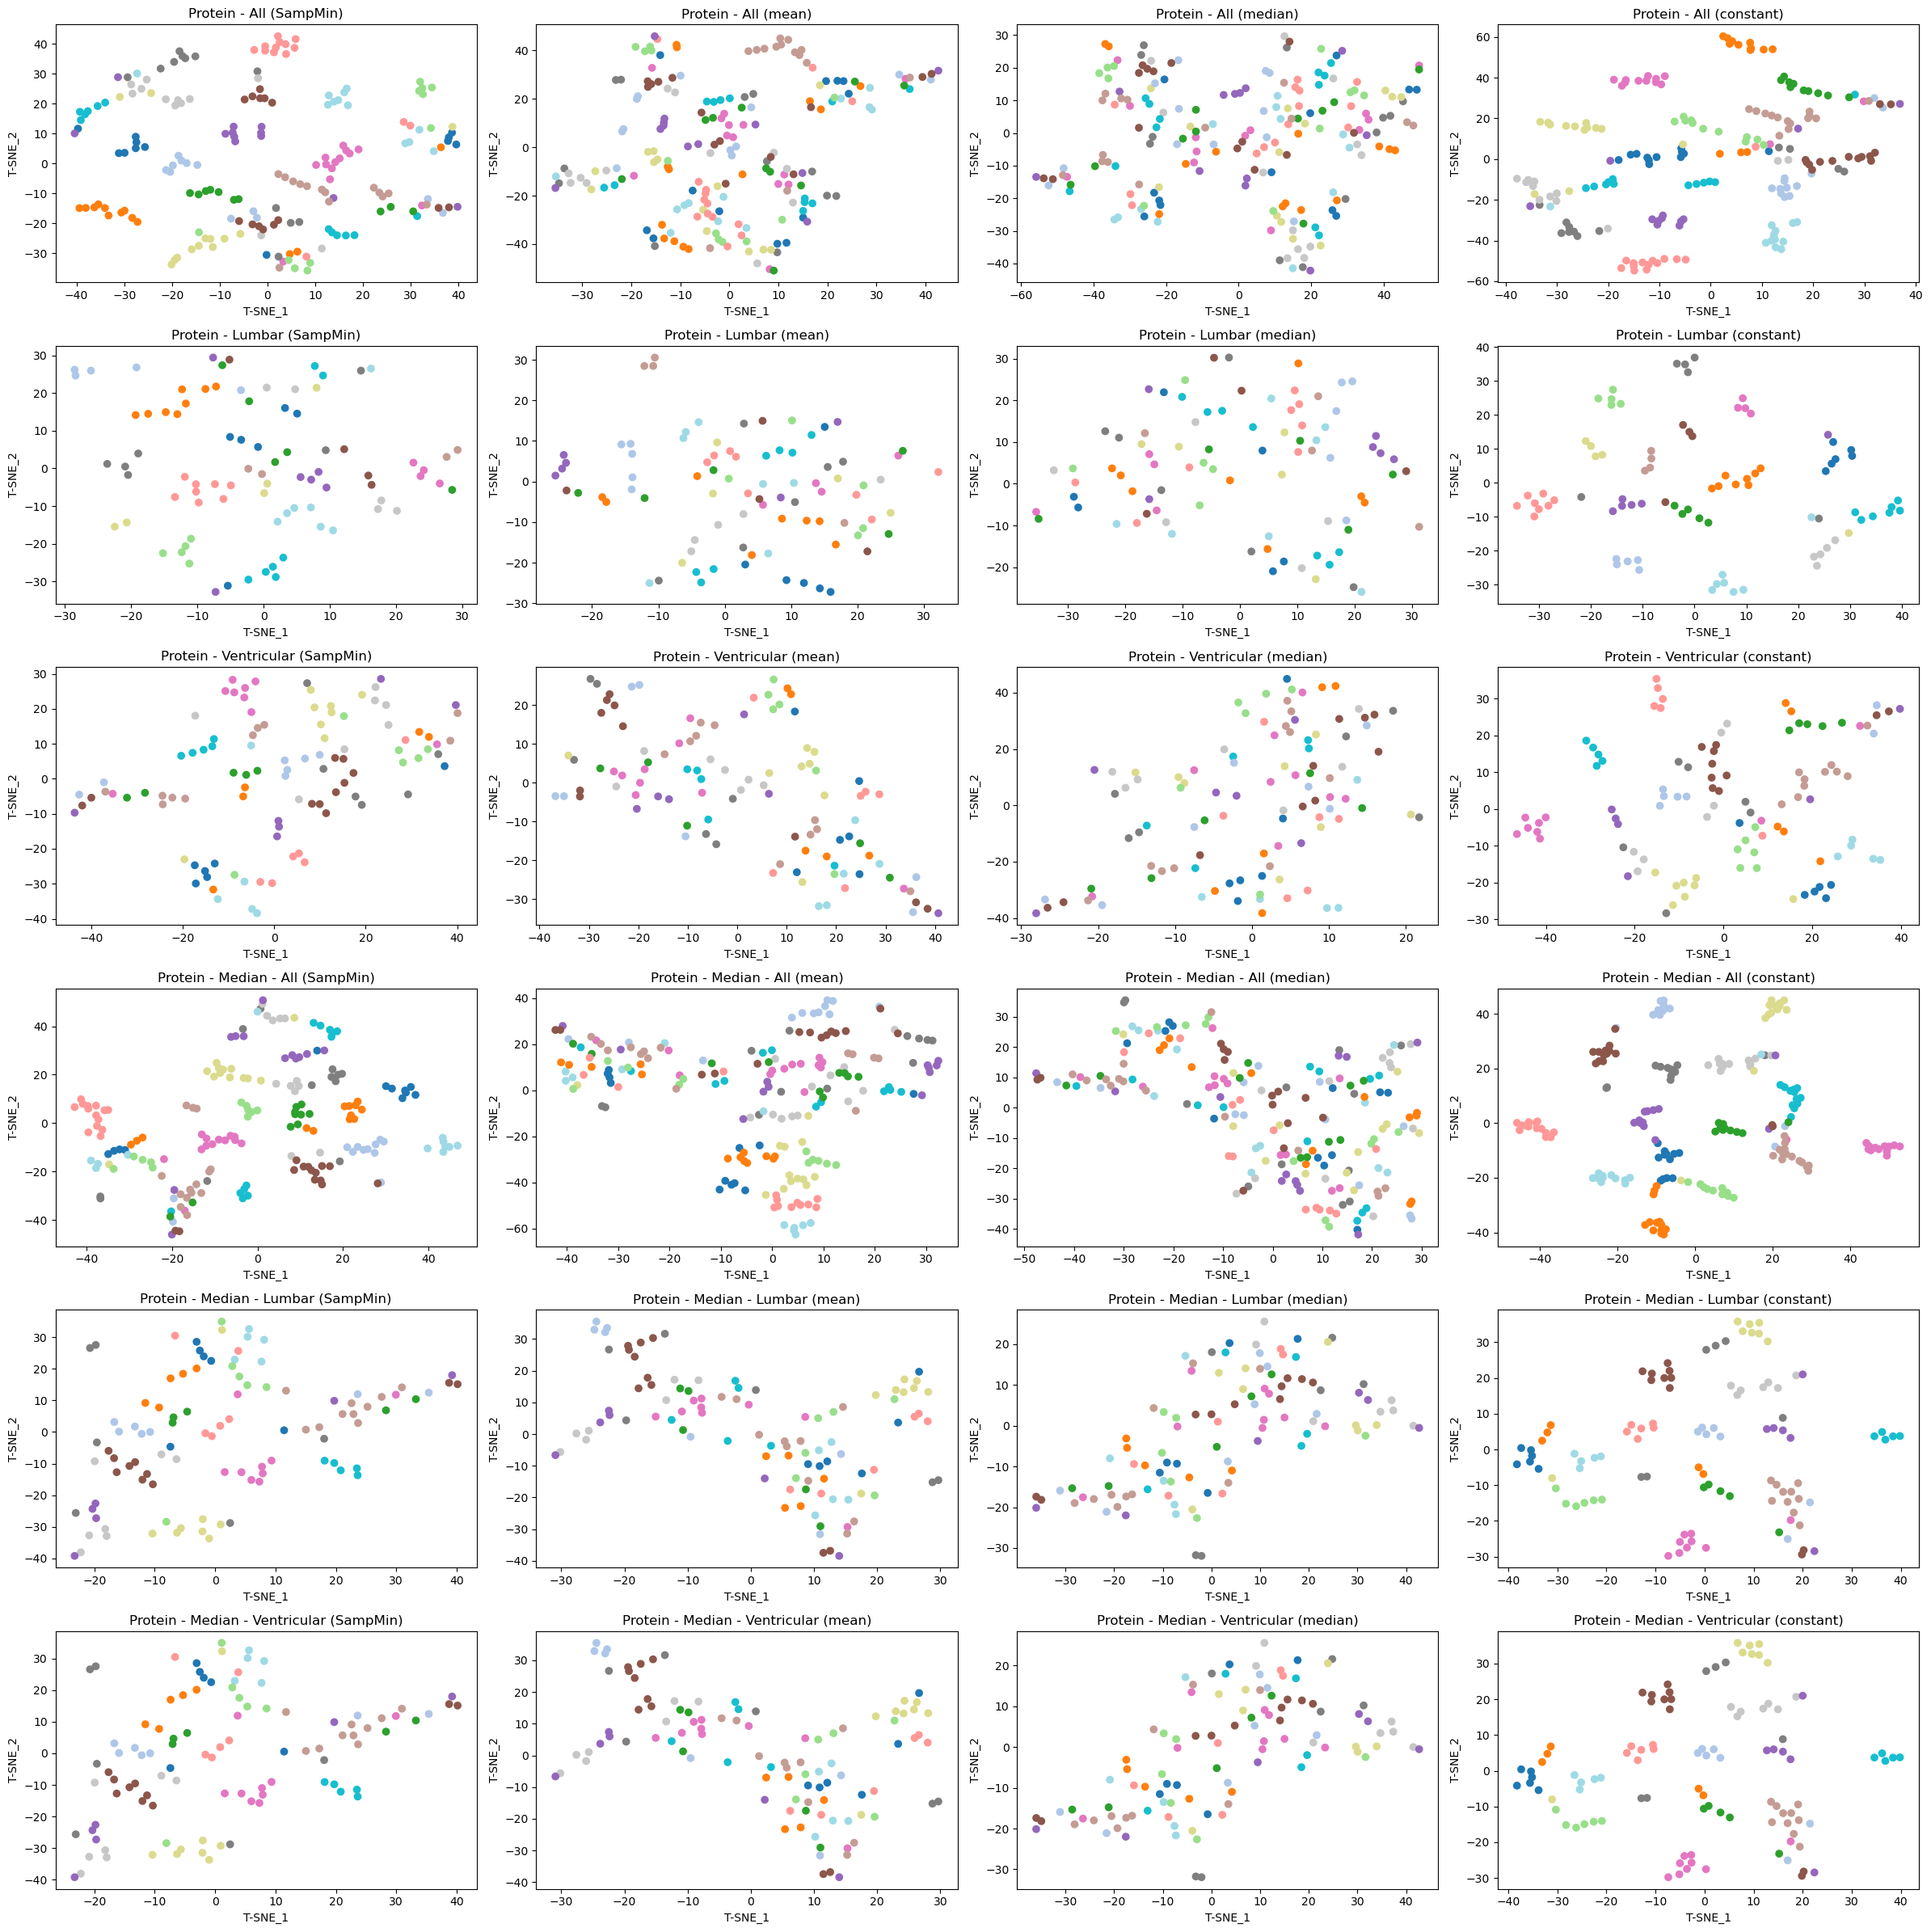

In [57]:
#Removes unnecessary warning
warnings.filterwarnings("ignore", message="Skipping features without any observed values")
dfs_protein = [df_proteins_all.iloc[:, 11:], df_proteins_all[df_proteins_all['CSF_type'] == 'L'].iloc[:, 11:], df_proteins_all[df_proteins_all['CSF_type'] == 'V'].iloc[:, 11:],
       df_proteins_median_all.iloc[:, 11:], df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V'].iloc[:, 11:], df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V'].iloc[:, 11:]]
cs_protein = [df_proteins_all["TMT Set"], df_proteins_all[df_proteins_all['CSF_type'] == 'L']["TMT Set"], df_proteins_all[df_proteins_all['CSF_type'] == 'V']["TMT Set"],
      df_proteins_median_all["TMT Set"], df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V']["TMT Set"], df_proteins_median_all[df_proteins_median_all['CSF_type'] == 'V']["TMT Set"]]
titles_protein = ['Protein - All', 'Protein - Lumbar', 'Protein - Ventricular', 'Protein - Median - All', 'Protein - Median - Lumbar', 'Protein - Median - Ventricular']
impute_and_plot(dfs_protein, cs_protein, titles_protein)

#### Peptides

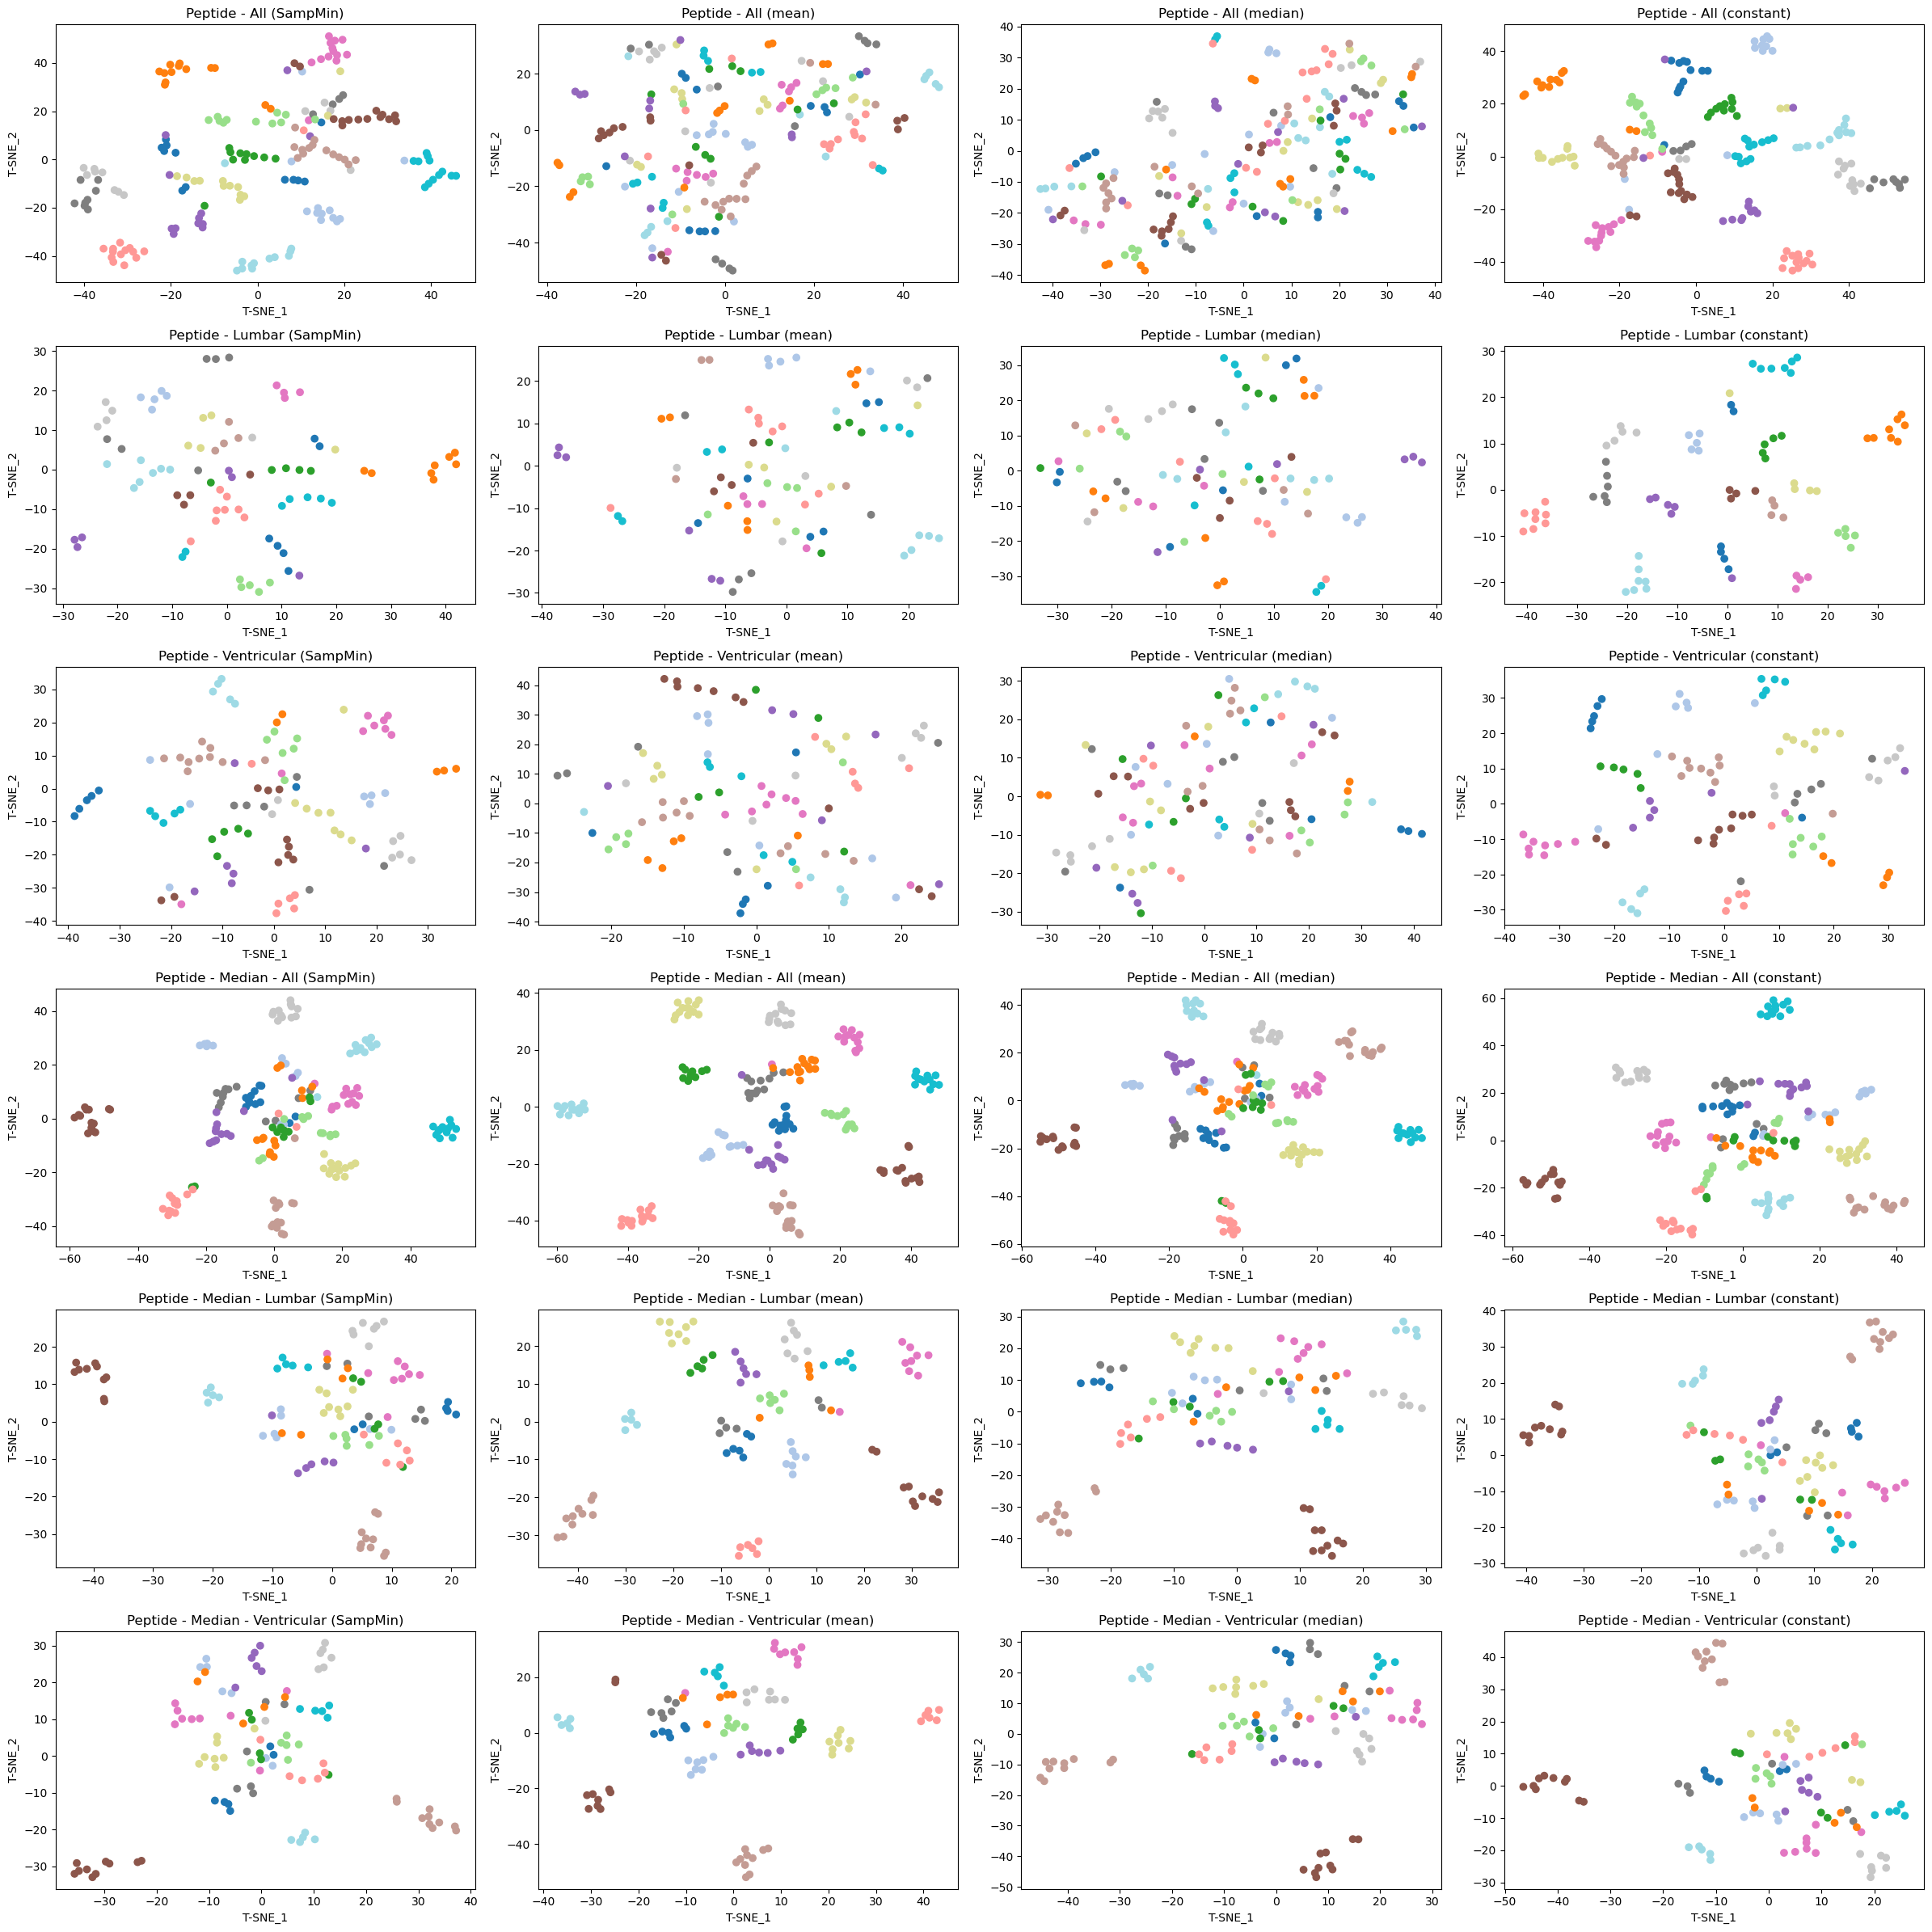

In [58]:
dfs_peptides = [df_peptides_all.iloc[:, 11:], df_peptides_all[df_peptides_all['CSF_type'] == 'L'].iloc[:, 11:], df_peptides_all[df_peptides_all['CSF_type'] == 'V'].iloc[:, 11:],
       df_peptides_median_all.iloc[:, 11:], df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'V'].iloc[:, 11:], df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'V'].iloc[:, 11:]]
cs_peptides = [df_peptides_all["TMT Set"], df_peptides_all[df_peptides_all['CSF_type'] == 'L']["TMT Set"], df_peptides_all[df_peptides_all['CSF_type'] == 'V']["TMT Set"],
      df_peptides_median_all["TMT Set"], df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'V']["TMT Set"], df_peptides_median_all[df_peptides_median_all['CSF_type'] == 'V']["TMT Set"]]
titles_peptides = ['Peptide - All', 'Peptide - Lumbar', 'Peptide - Ventricular', 'Peptide - Median - All', 'Peptide - Median - Lumbar', 'Peptide - Median - Ventricular']
impute_and_plot(dfs_peptides, cs_peptides, titles_peptides)

## Batch Correction

Below, we apply the ComBat batch effect correction algorithm to make a simple investigation of the batch effect after imputing protein lumbar data with SampMin.

In [59]:
imputer = SampMin(strategy="SampMin", missing_values=np.nan)
data = imputer.fit_transform(df_proteins_all.iloc[:, 11:])
data_corrected = pycombat(data.T,df_proteins_all["TMT Set"])

Found 15 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


c:\Users\Toffe\anaconda3\Lib\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


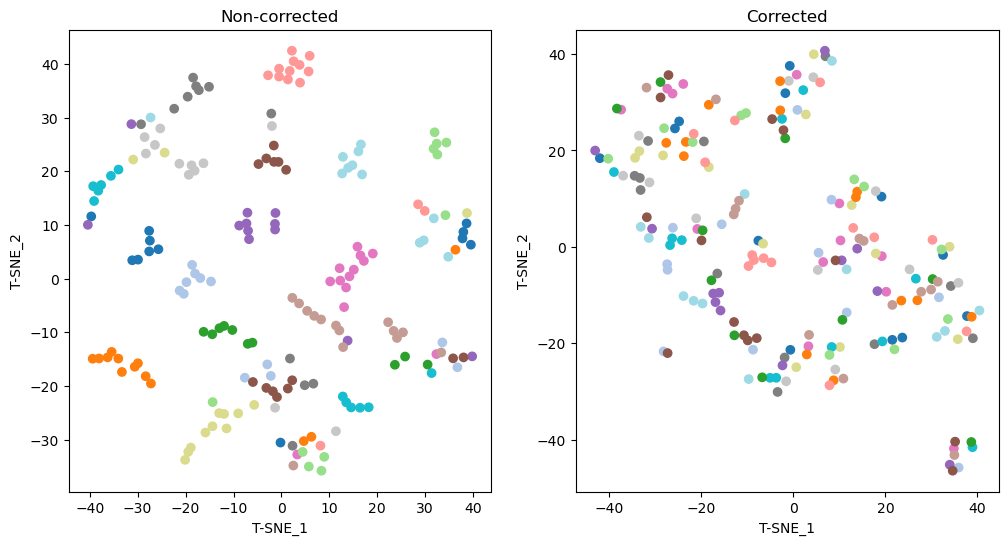

In [60]:
#--- PLOTTING T-SNE COMPARING BATCH-CORRECTED AND NON-CORRECTED PLOT ---#
tsne = TSNE(n_components=2, perplexity=5)
tsne_1 = tsne.fit_transform(data)
tsne_2 = tsne.fit_transform(data_corrected.T)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_tnses(tsne_1, df_proteins_all["TMT Set"], "Non-corrected", axes[0])
plot_tnses(tsne_2, df_proteins_all["TMT Set"], "Corrected", axes[1])

By observing the two above plots. We can clearly see that the batch effect is not as appearant after applying ComBat. However, further investigation is neccessary to ensure the data quality is fine. It's also worth to investigate after the data is imputed with a more refined imputation technique such as MICE.

# TODO

* Some imputation techniques such as GSIMP assumes a normal distribution.
Can we assume data follows a normal dist. after log_2 transform?

* After runnning batch correction algorithm, such as ComBat. Do we need to somehow validate the generated data?